In [1]:
import xarray as xr
import numpy  as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.style import use as usestyle
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
import matplotlib as mpl
from time import perf_counter
import xesmf
import cartopy.crs as ccrs
from cartopy import feature as cfeature
import os
import pandas as pd
from glob import glob
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
from matplotlib import ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from astropy.convolution import convolve

In [2]:
usestyle("paperplots.mplstyle")
from matplotlib import rcParams
rcParams["figure.titlesize"] = 12
rcParams["axes.titlesize"] = 10
rcParams["axes.labelsize"] = 8
rcParams["xtick.labelsize"] = 8
rcParams["ytick.labelsize"] = 8
rcParams["axes.linewidth"] = 0.4

In [3]:
class MidpointNormalize(colors.Normalize):
    #Allows for asymmetric colormap normalization
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    #Used for terrain colormaps to eliminate the unused portion of the colormap which is better for water.
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
def make_metpycompliant(afile, polelat, polelon):
    #Unfortunately, metpy requires some specific dimension names, and also gets mad if
    #we have two different latitude/longitude coordinates, so we need to rename some
    #stuff in our post-processed files and get rid of the 1D lat/lon coords
    afile = afile.drop(["lat1d", "lon1d"]).rename({"z": "vertical", "lat2d": "lat", "lon2d": "lon"})
    afile = afile.metpy.assign_crs(grid_mapping_name = "stereographic", latitude_of_projection_origin = polelat, longitude_of_projection_origin = polelon, scale_factor_at_projection_origin = 1)
    return afile

In [5]:
def add_cartofeatures_fulldomain(geoax):
    #Add cartopy features for plots covering the full model domain
    geoax.set_extent((controlgrid["x"].min(), controlgrid["x"].max(), controlgrid["y"].min(), controlgrid["y"].max()), crs = ramscrs)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-83, -79, -75])
    gl.ylocator = mticker.FixedLocator([38, 40, 42, 44, 46])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    return geoax

In [6]:
def add_cartofeatures_zoomdomain(geoax):
    #Add cartopy features for plots focusing on the region over Lakes Erie and Huron
    geoax.set_extent((controlgrid["x"][50], controlgrid["x"][650], controlgrid["y"][450], controlgrid["y"][1050]), crs = ramscrs)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-84, -82, -80, -78])
    gl.ylocator = mticker.FixedLocator([42, 43, 44, 45, 46])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    return geoax

In [7]:
def add_cartofeatures_snowbox(geoax):
    #Add cartopy features for plots showing snowfall downwind of Lake Erie
    geoax.set_extent((controlgrid["x"][200], controlgrid["x"][750], controlgrid["y"][150], controlgrid["y"][650]), crs = ramscrs)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-82, -81, -80, -79, -78])
    gl.ylocator = mticker.FixedLocator([38, 39, 40, 41, 42])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    return ax

In [8]:
def get_profilermse(obstemp, obsdwpt, obsu, obsv, obsheight, simtemp, simdwpt, simu, simv, simheight):
    #First, restrict temperatures/dewpoints to below the PBL top, which for LES we can roughly define as where the inversion begins
    simpbltop = np.argwhere(np.diff(simtemp)>0).min()
    simpblbot = np.argwhere(np.logical_not(np.isnan(simtemp))).min()
    obspbltop = np.argwhere(np.diff(obstemp)>0).min()
    minpbltop = np.argmin(np.abs(simheight - np.min([simheight[simpbltop], obsheight[obspbltop]])))
    simpbltemp = simtemp[simpblbot:minpbltop]
    simpblheight = simheight[simpblbot:minpbltop]
    simpbldwpt = simdwpt[simpblbot:minpbltop]
    simpblu = simu[simpblbot:minpbltop]
    simpblv = simv[simpblbot:minpbltop]
    obspbltemp = obstemp[0:obspbltop]
    obspbldwpt = obsdwpt[0:obspbltop]
    obspblheight = obsheight[0:obspbltop]
    obspblu = obsu[0:obspbltop]
    obspblv = obsv[0:obspbltop]

    interp_obspbltemp = np.interp(simpblheight, obspblheight, obspbltemp)
    interp_obspbldwpt = np.interp(simpblheight, obspblheight, obspbldwpt)
    interp_obspblu = np.interp(simpblheight, obspblheight, obspblu)
    interp_obspblv = np.interp(simpblheight, obspblheight, obspblv)

    rmse_tempdiff = np.nanmean((simpbltemp - interp_obspbltemp)**2)**(1/2)
    rmse_dwptdiff = np.nanmean((simpbldwpt - interp_obspbldwpt)**2)**(1/2)
    rmse_udiff = np.nanmean((simpblu - interp_obspblu)**2)**(1/2)
    rmse_vdiff = np.nanmean((simpblv - interp_obspblv)**2)**(1/2)

    return({"Temp_RMSE": rmse_tempdiff, "Dewpoint_RMSE": rmse_dwptdiff, "U_RMSE": rmse_udiff, "V_RMSE": rmse_vdiff, 
            "Temp_Bias": np.nanmean(simpbltemp - interp_obspbltemp), "Dewpoint_Bias": np.nanmean(simpbldwpt - interp_obspbldwpt), 
            "U_Bias": np.nanmean(simpblu - interp_obspblu), "V_Bias": np.nanmean(simpblv - interp_obspblv)})

## Establish directories for files for CONTROL and NLH

In [9]:
controlpath = input("Enter the directory containing post-processed output from the CONTROL simulation: ").rstrip("/ ")
if not os.path.exists(controlpath):
    raise Exception("Control post-processed file directory not found!")
nlhpath = input("Enter the directory containing post-processed output from the NLH simulation: ").rstrip("/ ")
if not os.path.exists(nlhpath):
    raise Exception("NLH post-processed file directory not found!")

Enter the directory containing post-processed output from the CONTROL simulation:  /moonbow/ascheb/les/2010/hires_control/processed_data
Enter the directory containing post-processed output from the NLH simulation:  /moonbow/ascheb/les/2010/hires_nolake/processed_data


In [10]:
gridsmade = input("Have you made grid files for the CONTROL and NLH simulations? These are just files which contain basic information about coordinates, patch areas, and terrain height. If yes, there should be NetCDF files in the directory with the data for each simulation with the name 'gridconsts.nc'. Enter 'yes' or 'no': ")
if gridsmade.lower().strip() == "yes":
    gridsmade = True
elif gridsmade.lower().strip() == "no":
    gridsmade = False
else:
    raise Exception("Answer must be either 'yes' or 'no'!")
if gridsmade:
    controlgridpath = input("Enter the directory containing the gridconsts.nc file for the CONTROL simulation: ").rstrip("/ ")
    nlhgridpath = input("Enter the directory containing the gridconsts.nc file for the NLH simulation: ").rstrip("/ ")
    if not os.path.exists(f"{controlgridpath}/gridconsts.nc"):
        raise Exception("Control grid file not found!")
    if not os.path.exists(f"{nlhgridpath}/gridconsts.nc"):
        raise Exception("NLH grid file not found!")
    controlgrid = xr.open_dataset(f"{controlgridpath}/gridconsts.nc")
    nlhgrid = xr.open_dataset(f"{nlhgridpath}/gridconsts.nc")
else:
    control_file_init = xr.open_dataset(f"{controlpath}/mvars-cart-2010-01-02-180000-g1.nc")
    nlh_file_init = xr.open_dataset(f"{nlhpath}/mvars-cart-2010-01-02-180000-g1.nc")
    controlgrid = control_file_init[["PatchArea", "Topo"]]
    nlhgrid = nlh_file_init[["PatchArea", "Topo"]]
    control_file_init.close(); del control_file_init
    nlh_file_init.close(); del nlh_file_init
    controlgridpath = input("Enter the directory where you want to put the gridconsts.nc file for the CONTROL simulation: ").rstrip("/ ")
    nlhgridpath = input("Enter the directory where you want to put the gridconsts.nc file for the NLH simulation: ").rstrip("/ ")
    controlgrid.to_netcdf(f"{controlgridpath}/gridconsts.nc")
    nlhgrid.to_netcdf(f"{nlhgridpath}/gridconsts.nc")

Have you made grid files for the CONTROL and NLH simulations? These are just files which contain basic information about coordinates, patch areas, and terrain height. If yes, there should be NetCDF files in the directory with the data for each simulation with the name 'gridconsts.nc'. Enter 'yes' or 'no':  yes
Enter the directory containing the gridconsts.nc file for the CONTROL simulation:  /moonbow/ascheb/les/2010/hires_control
Enter the directory containing the gridconsts.nc file for the NLH simulation:  /moonbow/ascheb/les/2010/hires_nolake


## Skew-T Comparison Between Obs and CONTROL

In [11]:
jan3lines = []
with open("/moonbow/ascheb/les/2010/bufsoundings_por.txt") as porsndfile:
    for line in porsndfile:
        linelist = line.split(" ")
        if linelist[1] == "2010" and linelist[2] == "01" and linelist[3] == "03" and linelist[4] == "00":
            preslevs = int(linelist[7])
            jan3lines = [porsndfile.readline().split(" ") for i in range(0,preslevs)]
            break #Done with the file since we've got the date we need
jan3trimlines = []
templist = []
for i,entry in enumerate(jan3lines):
    for j, field in enumerate(entry):
        if field not in("", "\n"):
            templist.append(float(field.rstrip("B")))
    if not templist[2] == -9999:
        jan3trimlines.append(np.copy(templist))
        templist.clear()
jan3array = np.asarray(jan3trimlines)
parray, heightarray, temparray, dwptarray, uarray, varray = [np.zeros(len(jan3array[:,0])) for i in range(0,6)]
parray = jan3array[:,2]/100
heightarray = jan3array[:,3]
temparray = jan3array[:,4]/10 + 273
dwptarray = jan3array[:,4]/10 - jan3array[:,6]/10 + 273
uarray = -1*jan3array[:,8]/10 * np.sin(jan3array[:,7] * np.pi/180)
varray = -1*jan3array[:,8]/10 * np.cos(jan3array[:,7] * np.pi/180)
buflat = 42.9411 #Degrees N
buflon = -78.7189 #Degrees E
bufalt = 218.4 #m AMSL
bufsnddata = pd.DataFrame({"Pressure": np.where(parray > -99999, parray, np.nan),
                           "Height": np.where(heightarray > -99999, heightarray, np.nan),
                           "Temperature": np.where(temparray > -99999, temparray, np.nan),
                           "Dewpoint": np.where(dwptarray > -99999, dwptarray, np.nan),
                           "u": np.where(np.abs(uarray) < 99999, uarray, np.nan),
                           "v": np.where(np.abs(varray) < 99999, varray, np.nan)})

In [12]:
#First, load data from 0000 UTC on 3 January to compare against the radiosonde from Buffalo Intl. Airport
ftime = "2010-01-03-000000"
afile_control = xr.open_dataset(f"{controlpath}/mvars-cart-{ftime}-g1.nc")
controlthermo = afile_control[["Temperature","Pressure", "Dewpoint", "u", "v"]]

In [13]:
from scipy.interpolate import RegularGridInterpolator
control_tempinterp = RegularGridInterpolator((controlthermo["z"].values, controlthermo["lat1d"].values, controlthermo["lon1d"].values), controlthermo["Temperature"].values)
control_dwptinterp = RegularGridInterpolator((controlthermo["z"].values, controlthermo["lat1d"].values, controlthermo["lon1d"].values), controlthermo["Dewpoint"].values)
control_presinterp = RegularGridInterpolator((controlthermo["z"].values, controlthermo["lat1d"].values, controlthermo["lon1d"].values), controlthermo["Pressure"].values)
control_uinterp = RegularGridInterpolator((controlthermo["z"].values, controlthermo["lat1d"].values, controlthermo["lon1d"].values), controlthermo["u"].values)
control_vinterp = RegularGridInterpolator((controlthermo["z"].values, controlthermo["lat1d"].values, controlthermo["lon1d"].values), controlthermo["v"].values)
bufpts = np.zeros((len(controlthermo["z"].values),3))

bufpts[:,0] = controlthermo["z"].values
bufpts[:,1] = buflat
bufpts[:,2] = buflon

buf_interptemp_control = control_tempinterp(bufpts)
buf_interpdwpt_control = control_dwptinterp(bufpts)
buf_interppres_control = control_presinterp(bufpts)
buf_interpu_control = control_uinterp(bufpts)
buf_interpv_control = control_vinterp(bufpts)

simpbltop_index = np.argwhere(np.diff(buf_interptemp_control)>0).min()
simpbltop_height = bufpts[simpbltop_index,0]
simpbltop_pressure = buf_interppres_control[simpbltop_index]
obspbltop_index = np.argwhere(np.diff(bufsnddata["Temperature"].values)>0).min()
obspbltop_height = bufsnddata["Height"].values[obspbltop_index]
obspbltop_pressure = bufsnddata["Pressure"].values[obspbltop_index]

print(f"CONTROL PBL top pressure: {simpbltop_pressure:.02f} hPa. Buffalo sounding PBL top pressure: {obspbltop_pressure:.02f} hPa \nCONTROL PBL top height: {simpbltop_height:.02f} m. Buffalo sounding PBL top height: {obspbltop_height:.02f} m.")
rmsedict = get_profilermse(bufsnddata["Temperature"].values, bufsnddata["Dewpoint"].values, bufsnddata["u"].values, bufsnddata["v"].values, bufsnddata["Height"].values, buf_interptemp_control, buf_interpdwpt_control, buf_interpu_control, buf_interpv_control, bufpts[:,0])
printftime = f'{datetime.strptime(ftime, "%Y-%m-%d-%H%M%S").strftime("%H%M")} UTC on {datetime.strptime(ftime, "%Y-%m-%d-%H%M%S").strftime("%d")} Jan'
print(f"Root Mean Square Error of temperature between Buffalo sounding and CONTROL at {printftime}: {rmsedict['Temp_RMSE']:.02f} K. \nRoot Mean Square Error of dewpoint between Buffalo sounding and CONTROL at {printftime}: {rmsedict['Dewpoint_RMSE']:.02f} K.")

print(f"Mean bias of temperature at Buffalo in CONTROL compared to sounding at {printftime}: {rmsedict['Temp_Bias']:.02f} K. \nMean bias of dewpoint at Buffalo in CONTROL compared to sounding at {printftime}: {rmsedict['Dewpoint_Bias']:.02f} K.")

print(f"Root Mean Square Error of u between Buffalo sounding and CONTROL at {printftime}: {rmsedict['U_RMSE']:.02f} m/s. \nRoot Mean Square Error of v between Buffalo sounding and CONTROL at {printftime}: {rmsedict['V_RMSE']:.02f} m/s.")

print(f"Mean bias of u at Buffalo in CONTROL compared to sounding at {printftime}: {rmsedict['U_Bias']:.02f} m/s. \nMean bias of v at Buffalo in CONTROL compared to sounding at {printftime}: {rmsedict['V_Bias']:.02f} m/s.")


CONTROL PBL top pressure: 871.42 hPa. Buffalo sounding PBL top pressure: 850.00 hPa 
CONTROL PBL top height: 1144.23 m. Buffalo sounding PBL top height: 1367.00 m.
Root Mean Square Error of temperature between Buffalo sounding and CONTROL at 0000 UTC on 03 Jan: 0.39 K. 
Root Mean Square Error of dewpoint between Buffalo sounding and CONTROL at 0000 UTC on 03 Jan: 1.17 K.
Mean bias of temperature at Buffalo in CONTROL compared to sounding at 0000 UTC on 03 Jan: -0.36 K. 
Mean bias of dewpoint at Buffalo in CONTROL compared to sounding at 0000 UTC on 03 Jan: 0.40 K.
Root Mean Square Error of u between Buffalo sounding and CONTROL at 0000 UTC on 03 Jan: 0.54 m/s. 
Root Mean Square Error of v between Buffalo sounding and CONTROL at 0000 UTC on 03 Jan: 6.43 m/s.
Mean bias of u at Buffalo in CONTROL compared to sounding at 0000 UTC on 03 Jan: -0.05 m/s. 
Mean bias of v at Buffalo in CONTROL compared to sounding at 0000 UTC on 03 Jan: -5.65 m/s.


In [17]:
import metpy.calc as mcalc
from metpy.plots import SkewT
from metpy.units import units
from matplotlib import rcParams
tfig = plt.figure(figsize = (5.5, 6), dpi = 200)
barblevels = [0, 15, 30, 45, 60, 70, 80, 90, 97]
testskew = SkewT(tfig, rotation = 45)
testskew.ax.set_ylim(1050, 300)
testskew.ax.set_xlim(-40, 2)
testskew.ax.tick_params(labelsize = 8)
contemp, = testskew.plot(buf_interppres_control*units.hPa, buf_interptemp_control-273.15, color = "red", label = "CONTROL Temperature", linewidth = 1)
nlhtemp, = testskew.plot(bufsnddata["Pressure"]*units.hPa, bufsnddata["Temperature"]-273.15, color = "maroon", label = "Observed Temperature", linewidth = 1)
condew, = testskew.plot(buf_interppres_control*units.hPa, buf_interpdwpt_control-273.15, color = "dodgerblue", label = "CONTROL Dewpoint", linewidth = 1)
nlhdew, = testskew.plot(bufsnddata["Pressure"]*units.hPa, bufsnddata["Dewpoint"]-273.15, color = "midnightblue", label = "Observed Dewpoint", linewidth = 1)
obswind = testskew.plot_barbs(buf_interppres_control[barblevels]*units.hPa, np.interp(controlthermo["z"].values, bufsnddata["Height"], bufsnddata["u"])[barblevels]*units.meter/units.second, np.interp(controlthermo["z"].values, bufsnddata["Height"], bufsnddata["v"])[barblevels]*units.meter/units.second, color = "black", label = "Observed Wind", plot_units = units.knots)
simwind = testskew.plot_barbs(buf_interppres_control[barblevels]*units.hPa, buf_interpu_control[barblevels]*units.meter/units.second, buf_interpv_control[barblevels]*units.meter/units.second, color = "darkviolet", label = "CONTROL Wind", plot_units = units.knots)
dryads = testskew.plot_dry_adiabats(t0 = np.arange(-40, 200, 10)*units.degC, colors = "tomato", linewidths = 0.75, label = "Dry Adiabats", alpha = 0.5)
moistads = testskew.plot_moist_adiabats(t0 = np.arange(-40, 45, 5)*units.degC, colors = "dodgerblue", linewidths = 0.75, label = "Moist Adiabats", alpha = 0.5)
proflegend = testskew.ax.legend(framealpha = 0, fontsize = 8, loc = "lower left", bbox_to_anchor = (0, -0.01), handles = [contemp, nlhtemp, condew, nlhdew])
testskew.ax.add_artist(proflegend)
backlegend = testskew.ax.legend(framealpha = 0, fontsize = 8, loc = "lower right", handles = [dryads, moistads])
barblegend = testskew.ax.legend(framealpha = 0, fontsize = 8, loc = "upper left", handles = [obswind, simwind])
testskew.ax.add_artist(backlegend)
testskew.ax.set_ylabel("Pressure (hPa)", fontsize = 13)
testskew.ax.set_xlabel(r"Temperature ($\mathrm{\degree C}$)", fontsize = 13)
testskew.ax.set_title("Simulated and Observed Thermodynamic Profiles \n at KBUF at 0000 UTC 3 January 2010", fontsize = 13)
plt.savefig("../PaperFigs/bufsndverif.png")
plt.close()
del tfig

In [18]:
sim_850height = np.argmin(np.abs(np.where(np.logical_not(np.isnan(buf_interppres_control)), buf_interppres_control, 0) - 850))
sim_pblheight = np.argwhere(np.diff(buf_interptemp_control)>0).min()

print(sim_850height, sim_pblheight)
sim_botheight = np.argwhere(np.logical_not(np.isnan(buf_interptemp_control))).min()
# print(buf_interppres_control[44])
obs_850height = np.argmin(np.abs(bufsnddata["Pressure"].values - 850))
obs_pblheight = np.argwhere(np.diff(bufsnddata["Temperature"].values) > 0).min()
# simpbltemp = buf_interptemp_control[simpblbot:minpbltop]
# simpblheight = afile_control["z"].values[simpblbot:minpbltop]
# simpbldwpt = simdwpt[simpblbot:minpbltop]
# obspbltemp = bufsnddata["Temperature"].values[0:obspbltop]
# obspbldwpt = obsdwpt[0:obspbltop]
# obspblheight = bufsnddata["z"].values[0:obspbltop]
# print(buf_interptemp_control)

# print(afile_control["Temperature"].values[np.
lakebox = xr.open_dataset("lakebox.nc")
sst_control = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/ssth-W-2009-12-27-000000-g1.h5").isel(phony_dim_1 = slice(1, 999), phony_dim_0 = slice(1, 1099)).rename({"phony_dim_1": "x", "phony_dim_0": "y"}).assign_coords({"x": controlgrid["x"], "y": controlgrid["y"]})
sst_vartemp = xr.open_dataset("/moonbow/ascheb/les/2010/hires_vartemp/ssth-W-2009-12-27-000000-g1.h5").isel(phony_dim_1 = slice(1, 999), phony_dim_0 = slice(1, 1099)).rename({"phony_dim_1": "x", "phony_dim_0": "y"}).assign_coords({"x": controlgrid["x"], "y": controlgrid["y"]})

eriesst_control = (sst_control["SEATF"].interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("normal", "tangent"))
eriesst_vartemp = (sst_vartemp["SEATF"].interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("normal", "tangent"))

delta850_obs = eriesst_vartemp - bufsnddata["Temperature"][obs_850height]
delta850_sim = eriesst_control - buf_interptemp_control[sim_850height]

lapse_obs = (bufsnddata["Temperature"][0] - bufsnddata["Temperature"][obs_pblheight]) / (bufsnddata["Height"][obs_pblheight] - bufsnddata["Height"][0])
lapse_sim = (buf_interptemp_control[sim_botheight] - buf_interptemp_control[sim_pblheight]) / (afile_control["z"][sim_pblheight].values - afile_control["z"][sim_botheight].values)

44 38


In [19]:
print(f"Difference between lake temperature and 850mb temperature in the Buffalo sounding: {delta850_obs:.2f} K. In the CONTROL simulation: {delta850_sim:.2f} K")
print(f"Lapse rate between the surface and the PBL top in the Buffalo sounding {1000*lapse_obs:.2f} K. In the CONTROL simulation: {1000*lapse_sim:.2f} K")

Difference between lake temperature and 850mb temperature in the Buffalo sounding: 24.00 K. In the CONTROL simulation: 22.57 K
Lapse rate between the surface and the PBL top in the Buffalo sounding 7.83 K. In the CONTROL simulation: 7.08 K


In [20]:
sst_vartemp.close(); del sst_vartemp
sst_control.close(); del sst_control

In [21]:
afile_control.close(); del afile_control
controlthermo.close(); del controlthermo
del control_tempinterp
del control_presinterp
del control_dwptinterp
del control_uinterp
del control_vinterp

## Make a figure of the simulation domains (terrain height and water body location) as well as surface temperature and snow cover initialization

In [22]:
#Load varfiles to show initial snow cover and soil temperature
varinit_control = xr.open_dataset(f"{controlgridpath}/varfiles/var-V-2010-01-01-120000-g1.h5")
print(varinit_control.dims)
varinit_control = varinit_control.isel(phony_dim_1 = slice(1,1099), phony_dim_2 = slice(1, 999), phony_dim_0 = 1)
print(varinit_control)
varinit_nolake = xr.open_dataset(f"{nlhgridpath}/varfiles/var-V-2010-01-01-120000-g1.h5")
varinit_nolake = varinit_nolake.isel(phony_dim_1 = slice(1,1099), phony_dim_2 = slice(1, 999), phony_dim_0 = 1)

control_snowinitmask_full = np.where(controlgrid["PatchArea"].isel(patch = 1) == 1, varinit_control["SNOWMASS"].values, np.nan); print(control_snowinitmask_full.shape)
nolake_snowinitmask_full = np.where(nlhgrid["PatchArea"].isel(patch = 1) == 1, varinit_nolake["SNOWMASS"].values, np.nan); print(nolake_snowinitmask_full.shape)

Frozen({'phony_dim_0': 90, 'phony_dim_1': 1100, 'phony_dim_2': 1000, 'phony_dim_3': 1})
<xarray.Dataset>
Dimensions:     (phony_dim_1: 1098, phony_dim_2: 998, phony_dim_3: 1)
Dimensions without coordinates: phony_dim_1, phony_dim_2, phony_dim_3
Data variables: (12/25)
    COND        (phony_dim_1, phony_dim_2) float32 ...
    PI          (phony_dim_1, phony_dim_2) float32 ...
    RV          (phony_dim_1, phony_dim_2) float32 ...
    SNOWDEPTH   (phony_dim_1, phony_dim_2) float32 ...
    SNOWMASS    (phony_dim_1, phony_dim_2) float32 ...
    SOILMOIST1  (phony_dim_1, phony_dim_2) float32 ...
    ...          ...
    nx          (phony_dim_3) int32 ...
    ny          (phony_dim_3) int32 ...
    nz          (phony_dim_3) int32 ...
    polelat     (phony_dim_3) float32 ...
    polelon     (phony_dim_3) float32 ...
    year        (phony_dim_3) int32 ...
(1098, 998)
(1098, 998)


In [23]:
lhymin = 640; lhymax = 1040; lhxmin = 140; lhxmax = 420 #lh - main body of Lake Huron
gbymin = 800; gbymax = 1000; gbxmin = 420; gbxmax = 700 #gb - Georgian Bay and downwind land
gbpatchpoints = np.zeros((4, 2))
gbpatchpoints[:,0] = [controlgrid["x"].values[gbxmin], controlgrid["x"].values[gbxmax], controlgrid["x"].values[gbxmax], controlgrid["x"].values[gbxmin]]
gbpatchpoints[:,1] = [controlgrid["y"].values[gbymin], controlgrid["y"].values[gbymin], controlgrid["y"].values[gbymax], controlgrid["y"].values[gbymax]]

lhpatchpoints = np.zeros((4, 2))
lhpatchpoints[:,0] = [controlgrid["x"].values[lhxmin], controlgrid["x"].values[lhxmax], controlgrid["x"].values[lhxmax], controlgrid["x"].values[lhxmin]]
lhpatchpoints[:,1] = [controlgrid["y"].values[lhymin], controlgrid["y"].values[lhymin], controlgrid["y"].values[lhymax], controlgrid["y"].values[lhymax]]

In [24]:
sstfile = xr.open_dataset(f"{controlgridpath}/ssth-W-2009-12-27-000000-g1.h5")
controlsst = xr.DataArray(sstfile["SEATF"][1:-1,1:-1].values, coords = controlgrid["Topo"].coords, dims = controlgrid["Topo"].dims)
# # controlsst.assign_coords(controlgrid["Topo"].coords)
# controlsst.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
# controlsst.rio.write_crs(ccrs.Stereographic(central_longitude = -80, central_latitude = 42), inplace=True)
sstfile.close(); del sstfile

In [ ]:
# from shapely.geometry import mapping
# gdf = gpd.read_file("GL250310_lam.shp")
# clipsst = controlsst.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop = False)

### 4-panel version with hillshading

In [25]:
from matplotlib.colors import LightSource
hillshadegreycmap = mpl.colormaps.get_cmap("Greys")(np.linspace(0, 1, 256))
hillshadegreycmap[:,3] = abs(np.linspace(-0.5, 0.5, 256))
hillshadegreycmap = mpl.colors.ListedColormap(hillshadegreycmap)
print(hillshadegreycmap)
ls = LightSource (azdeg = 45, altdeg = 20)
topomp = ls.hillshade(controlgrid["Topo"].values, dx = 1000, dy = 1000, vert_exag = 50)
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (5, 7), sharex = True, sharey = True, dpi = 300, subplot_kw = {"projection": ramscrs}, layout = "compressed")
axlabels = ["(a)", "(b)", "(c)", "(d)"]
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128)
from palettable.lightbartlein.sequential import Blues10_10 as snowpalette
snowcmap = snowpalette.get_mpl_colormap().reversed()
from palettable.cartocolors.sequential import agSunset_7 as temppalette
tempcmap = temppalette.get_mpl_colormap()
from palettable.colorbrewer.sequential import BuPu_5 as waterpalette
watercmap = waterpalette.get_mpl_colormap()
for i, ax in enumerate(fig.get_axes()):
    ax = add_cartofeatures_fulldomain(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 5, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center", zorder = 6)
termp = ax1.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, transform = ramscrs, zorder = 0)
ax1.pcolormesh(controlgrid["x"], controlgrid["y"], topomp, cmap = hillshadegreycmap, vmin = 0, vmax = 1, transform = ramscrs, zorder = 2)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], nlhgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, transform = ramscrs)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], topomp, cmap = hillshadegreycmap, vmin = 0, vmax = 1, transform = ramscrs, zorder = 2)
# ax1.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["PatchArea"][0,:,:].where(controlgrid["PatchArea"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = watercmap, shading = "nearest", transform = ramscrs, zorder = 1)
sstmp = ax1.pcolormesh(controlgrid["x"], controlgrid["y"], np.where(controlgrid["PatchArea"][0,:,:]==1, controlsst, np.nan), cmap = "jet", vmin = 273.15, vmax = 279.15, transform = ramscrs, zorder = 2)
# ax2.pcolormesh(controlgrid["x"], controlgrid["y"], nlhgrid["PatchArea"][0,:,:].where(nlhgrid["PatchArea"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = watercmap, shading = "nearest", transform = ramscrs, zorder = 1)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], np.where(nlhgrid["PatchArea"][0,:,:]==1, controlsst, np.nan), cmap = "jet", vmin = 273.15, vmax = 279.15, transform = ramscrs, zorder = 2)
ax1.annotate("Lake Huron", [-82.7, 44.6], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 290, color = "black", transform = ccrs.PlateCarree(), zorder = 3)
ax1.annotate("Lake Erie", [-81.2, 42.1], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 23, color = "black", transform = ccrs.PlateCarree(), zorder = 3)
ax1.annotate("Lake Ont.", [-78, 43.6], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 0, color = "black", transform = ccrs.PlateCarree(), zorder = 3)
ax1.annotate("GB", [-80.7, 45.1], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 0, color = "black", transform = ccrs.PlateCarree(), zorder = 3)
ax2.add_patch(mpl.patches.Polygon(gbpatchpoints, edgecolor = "firebrick", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
ax2.add_patch(mpl.patches.Polygon(lhpatchpoints, edgecolor = "firebrick", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
buflat = 42.9411 #Degrees N
buflon = -78.7189 #Degrees E
ax2.scatter(buflon, buflat, c = "red", s = 8, zorder = 3, transform = ccrs.PlateCarree())
ax2.annotate("2", [-80.5, 43.5], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "cyan", transform = ccrs.PlateCarree())
ax2.annotate("1", [-82.3, 45.8], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "cyan", transform = ccrs.PlateCarree())
ax1.set_title("CONTROL"); ax3.set_title("CONTROL")
ax2.set_title("NLH"); ax4.set_title("NLH")
tercbar = fig.colorbar(termp, ax = [ax1], orientation = "horizontal", ticks = [0, 250, 500, 750, 1000], fraction = 0.05, aspect = 25, extend = "max"); tercbar.set_label("Terrain Height (m)")
sstcbar = fig.colorbar(sstmp, ax = [ax2], orientation = "horizontal", fraction = 0.05, aspect = 25, extend = "max"); sstcbar.set_label("Lake Temperature ($\mathrm{\degree C}$)"); sstcbar.ax.set_xticks(ticks = [273.15, 275.15, 277.15, 279.15], labels = ["0", "2", "4", "6"])
tempmp = ax3.pcolormesh(controlgrid["x"], controlgrid["y"], varinit_control["SOILTEMP1"], vmin = 270, vmax = 280, cmap = tempcmap, transform = ramscrs, zorder = 0)
snowmp1 = ax3.contour(controlgrid["x"], controlgrid["y"], varinit_control["SNOWMASS"], levels = [2, 5, 10, 20, 30, 50], cmap = snowcmap, norm = "log", zorder = 1, transform = ramscrs)
ax3.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["PatchArea"].isel(patch = 0).where(controlgrid["PatchArea"].isel(patch = 0) == 1), vmin = 0, vmax = 1, cmap = "Greys", zorder = 2, transform = ramscrs)
snowmp1.clabel(inline = True, fontsize = 6, zorder = 4)
ax4.pcolormesh(controlgrid["x"], controlgrid["y"], varinit_nolake["SOILTEMP1"], vmin = 270, vmax = 280, cmap = tempcmap, transform = ramscrs)
snowmp2 = ax4.contour(nlhgrid["x"], nlhgrid["y"], nolake_snowinitmask_full, levels = [2, 5, 10, 20, 30, 50], cmap = snowcmap, norm = "log")
snowmp2.clabel(inline = True, fontsize = 6, zorder = 4)
ax4.pcolormesh(nlhgrid["x"], nlhgrid["y"], nlhgrid["PatchArea"].isel(patch = 0).where(nlhgrid["PatchArea"].isel(patch = 0) == 1), vmin = 0, vmax = 1, cmap = "Greys", zorder = 1, transform = ramscrs)
tempcbar = fig.colorbar(tempmp, ax = [ax3,ax4], orientation = "horizontal", fraction = 0.1, extend = "both", aspect = 35, label = "Soil Temperature (K)")
fig.savefig("../PaperFigs/domaincarto-hillshade_4panel.png")
plt.close()
del fig; del ax1; del ax2; del ax3; del ax4

### Previous 2-Panel version of domain comparison without hillshading

In [26]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 3.5), sharex = True, sharey = True, dpi = 300, subplot_kw = {"projection": ramscrs})
axlabels = ["(a)", "(b)"]
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128)
for i, ax in enumerate(fig.get_axes()):
    ax = add_cartofeatures_fulldomain(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
termp = ax1.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, transform = ramscrs, zorder = 0)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], nlhgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, transform = ramscrs)
ax1.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["PatchArea"][0,:,:].where(controlgrid["PatchArea"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = "coolwarm_r", shading = "nearest", transform = ramscrs)
ax2.pcolormesh(controlgrid["x"], controlgrid["y"], nlhgrid["PatchArea"][0,:,:].where(nlhgrid["PatchArea"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = "coolwarm_r", shading = "nearest", transform = ramscrs)
ax2.plot([controlgrid["x"][lhxmin], controlgrid["x"][lhxmax]], [controlgrid["y"][lhymin], controlgrid["y"][lhymin]], color = "red", transform = ramscrs)
ax1.annotate("Lake Huron", [-82.7, 44.6], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 290, color = "white", transform = ccrs.PlateCarree())
ax1.annotate("Lake Erie", [-81.2, 42.1], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 23, color = "white", transform = ccrs.PlateCarree())
ax1.annotate("Lake Ont.", [-78, 43.6], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 0, color = "white", transform = ccrs.PlateCarree())
ax1.annotate("GB", [-80.7, 45.1], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 6.5, rotation = 0, color = "white", transform = ccrs.PlateCarree())
ax2.add_patch(mpl.patches.Polygon(gbpatchpoints, edgecolor = "firebrick", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
ax2.add_patch(mpl.patches.Polygon(lhpatchpoints, edgecolor = "firebrick", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
buflat = 42.9411 #Degrees N
buflon = -78.7189 #Degrees E
ax2.scatter(buflon, buflat, c = "red", s = 8, zorder = 3, transform = ccrs.PlateCarree())
ax2.annotate("2", [-80.5, 43.5], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "cyan", transform = ccrs.PlateCarree())
ax2.annotate("1", [-82.3, 45.8], horizontalalignment = "center", verticalalignment = "center", fontfamily = "sans", fontweight = "demibold", fontsize = 10, color = "cyan", transform = ccrs.PlateCarree())
ax1.set_title("CONTROL")
ax2.set_title("NLH")
tercbar = fig.colorbar(termp, ax = [ax1, ax2], orientation = "horizontal", ticks = [0, 250, 500, 750, 1000], fraction = 0.05, extend = "max"); tercbar.set_label("Terrain Height (m)")
fig.savefig("../PaperFigs/domaincarto_2panel.png")
plt.close()
del fig; del ax1; del ax2

In [27]:
varinit_control.close(); del varinit_control
varinit_nolake.close(); del varinit_nolake
del control_snowinitmask_full
del nolake_snowinitmask_full

## Calculating/Plotting Changes in Snowfall Between CONTROL and NLH

In [28]:
nolake_snow_old = xr.open_dataset(f"{nlhpath}/mvars-cart-2010-01-02-060000-g1.nc")
control_snow_old = xr.open_dataset(f"{controlpath}/mvars-cart-2010-01-02-060000-g1.nc")
nolake_snow_new = xr.open_dataset(f"{nlhpath}/mvars-cart-2010-01-03-060000-g1.nc")
control_snow_new = xr.open_dataset(f"{controlpath}/mvars-cart-2010-01-03-060000-g1.nc")

snowdiff_control = control_snow_new["SnowPrecipTotal"]+control_snow_new["AggPrecipTotal"]-control_snow_old["SnowPrecipTotal"]-control_snow_old["AggPrecipTotal"]
snowdiff_nolake = nolake_snow_new["SnowPrecipTotal"]+nolake_snow_new["AggPrecipTotal"]-nolake_snow_old["SnowPrecipTotal"]-nolake_snow_old["AggPrecipTotal"]

### Define boxes for evaluating snowfall in Regions A,B,C,D,E

In [29]:
ix0 = 400; iy0 = 525 #Northwest side of the "downwind of lake erie" box, at the center of the downwind shore
x0 = snowdiff_control["x"].isel(x = ix0); y0 = snowdiff_control["y"].isel(y = iy0); dxy = np.diff(snowdiff_control["x"])[0]
width = 400000; length = 305000 #m, dimensions of the box
tarray = np.arange(0, length+1, dxy); narray = np.arange(-width/2, width/2+1, dxy) #Coordinates of the box in tangent (long-axis) and normal (short-axis) directions. Normal is negative and positive (northeast and southwest), while tangent is only positive (to the right)
tmesh, nmesh = np.meshgrid(tarray, narray)
angle = np.pi/180*(-60) #Angle of the long axis of the box, with respect to the horizontal
xbox = x0.values+np.cos(angle)*tmesh-np.sin(angle)*nmesh
ybox = y0.values+np.sin(angle)*tmesh+np.cos(angle)*nmesh
snowbox = xr.DataArray(coords = {"y": (("normal", "tangent"), ybox), "x": (("normal", "tangent"), xbox), "normal": narray, "tangent": tarray}, dims = ["normal", "tangent"])

downwindsnow_control = snowdiff_control.interp(x = snowbox["x"], y = snowbox["y"])
downwindsnow_nolake = snowdiff_nolake.interp(x = snowbox["x"], y = snowbox["y"])

print(f"Average liquid equivalent of snowfall (mm) downwind of Lake Erie (Region A) in the CONTROl simulation \n{downwindsnow_control.mean():.2f} mm \nAverage liquid equivalent of snowfall downwind of Lake Erie (Region A) in the NLH simulation \n{downwindsnow_nolake.mean():.2f} mm\nRelative change in average snowfall downwind of Lake Erie (Region A) between CONTROL and NLH simulations \n{100*(downwindsnow_nolake.mean()-downwindsnow_control.mean())/downwindsnow_control.mean():.2f}% \nAverage CONTROL simulation snowfall downwind of Lake Erie (Region A) is {100*downwindsnow_control.mean()/downwindsnow_nolake.mean():.2f}% of average NLH simulation snowfall.")
print("\n\n")

patchpoints = np.zeros((4, 2))
patchpoints[:,0] = [downwindsnow_control["x"].values[0,0], downwindsnow_control["x"].values[0, -1], downwindsnow_control["x"].values[-1, -1], downwindsnow_control["x"].values[-1, 0]]
patchpoints[:,1] = [downwindsnow_control["y"].values[0,0], downwindsnow_control["y"].values[0, -1], downwindsnow_control["y"].values[-1, -1], downwindsnow_control["y"].values[-1, 0]]

print(f"Average liquid equivalent of snowfall in the main band (Region B) in CONTROL simulation \n{downwindsnow_control[210:250, 0:100].mean():.2f} mm \nAverage liquid equivalent of snowfall in the 'main band' (Region B) in NLH simulation \n{downwindsnow_nolake[210:250, 0:100].mean():.2f} mm\nRelative difference in average snowfall in the main band (Region B) between CONTROL and NLH simulation \n{100*(downwindsnow_control[210:250, 0:100].mean()-downwindsnow_nolake[210:250, 0:100].mean())/downwindsnow_control[210:250, 0:100].mean():.2f}% \nAverage CONTROL simulation snowfall in the main band (Region B) is {100*downwindsnow_control[210:250, 0:100].mean()/downwindsnow_nolake[210:250, 0:100].mean():.2f}% of average NLH simulation snowfall")
print("\n\n")
#Points 210:250, 0:100 form a rectangle roughly bounding the main snow band over Lake Erie in the CONTROL simulation
patchpointssub = np.zeros((4, 2)) #These are the points for box B in the figure below, outlining the main band
patchpointssub[:,0] = [downwindsnow_control["x"].values[210,0], downwindsnow_control["x"].values[210, 100], downwindsnow_control["x"].values[250, 100], downwindsnow_control["x"].values[250, 0]]
patchpointssub[:,1] = [downwindsnow_control["y"].values[210,0], downwindsnow_control["y"].values[210, 100], downwindsnow_control["y"].values[250, 100], downwindsnow_control["y"].values[250, 0]]
# print(downwindsnow_control[210:250, 0:100].mean(), downwindsnow_nolake[210:250, 0:100].mean(), downwindsnow_control[210:250, 0:100].sum()/downwindsnow_nolake[210:250, 0:100].sum())
# print(f"Average liquid equivalent of snowfall downwind of NE Lake Erie (Region D) in CONTROL simulation \n{downwindsnow_control[350:400, 0:100].mean():.2f} \nAverage liquid equivalent of snowfall downwind of NE Lake Erie (Region D) in NLH simulation \n{downwindsnow_nolake[350:400, 0:100].mean():.2f}\nRelative difference in average snowfall downwind of NE Lake Erie (Region D) between CONTROL and NLH simulation \n{100*(downwindsnow_control[350:400, 0:100].mean()-downwindsnow_nolake[350:400, 0:100].mean())/downwindsnow_control[350:400, 0:100].mean():.2f}% \nAverage CONTROL simulation snowfall downwind of NE Lake Erie (Region D) is {100*downwindsnow_control[350:400, 0:100].mean()/downwindsnow_nolake[350:400, 0:100].mean():.2f}% of average NLH simulation snowfall")
# #Change in snowfall in ne Lake Erie (Region D)
# #Points 350:4000, 0:100 form a rectangle roughly bounding the region of snowfall from the "brown lake" effect in NE Lake Erie
# print("\n\n")
# patchpointsne = np.zeros((4,2)) #Points bounding the band in northeast Lake Erie (box D)
# patchpointsne[:,0] = [downwindsnow_control["x"].values[350,0], downwindsnow_control["x"].values[350, 100], downwindsnow_control["x"].values[400, 100], downwindsnow_control["x"].values[400, 0]]
# patchpointsne[:,1] = [downwindsnow_control["y"].values[350,0], downwindsnow_control["y"].values[350, 100], downwindsnow_control["y"].values[400, 100], downwindsnow_control["y"].values[400, 0]]

patchpoints_between = np.zeros((4, 2)) #Points bounding area downwind of Lake Erie between box B and box D (box C)
patchpoints_between[:,0] = [downwindsnow_control["x"].values[250,0], downwindsnow_control["x"].values[250, 100], downwindsnow_control["x"].values[350, 100], downwindsnow_control["x"].values[350, 0]]
patchpoints_between[:,1] = [downwindsnow_control["y"].values[250,0], downwindsnow_control["y"].values[250, 100], downwindsnow_control["y"].values[350, 100], downwindsnow_control["y"].values[350, 0]]

print(f"Average liquid equivalent of snowfall in Region C in CONTROL simulation \n{downwindsnow_control[250:350, 0:100].mean():.2f} mm\nAverage liquid equivalent of snowfall in Region C in NLH simulation \n{downwindsnow_nolake[250:350, 0:100].mean():.2f} mm\nRelative difference in average snowfall in Region C between CONTROL and NLH simulation \n{100*(downwindsnow_control[250:350, 0:100].mean()-downwindsnow_nolake[250:350, 0:100].mean())/downwindsnow_control[250:350, 0:100].mean():.2f}% \nAverage CONTROL simulation snowfall in Region C is {100*downwindsnow_control[250:350, 0:100].mean()/downwindsnow_nolake[250:350, 0:100].mean():.2f}% of average NLH simulation snowfall")

Average liquid equivalent of snowfall (mm) downwind of Lake Erie (Region A) in the CONTROl simulation 
1.87 mm 
Average liquid equivalent of snowfall downwind of Lake Erie (Region A) in the NLH simulation 
1.57 mm
Relative change in average snowfall downwind of Lake Erie (Region A) between CONTROL and NLH simulations 
-15.91% 
Average CONTROL simulation snowfall downwind of Lake Erie (Region A) is 118.91% of average NLH simulation snowfall.



Average liquid equivalent of snowfall in the main band (Region B) in CONTROL simulation 
8.71 mm 
Average liquid equivalent of snowfall in the 'main band' (Region B) in NLH simulation 
2.38 mm
Relative difference in average snowfall in the main band (Region B) between CONTROL and NLH simulation 
72.62% 
Average CONTROL simulation snowfall in the main band (Region B) is 365.28% of average NLH simulation snowfall



Average liquid equivalent of snowfall in Region C in CONTROL simulation 
2.14 mm
Average liquid equivalent of snowfall in Region C in 

### Plot Snowfall Comparison between CONTROL and NLH

In [31]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize = (7.8, 6), dpi = 200, layout = "compressed", subplot_kw = {"projection": ramscrs})
startt = datetime(2010, 1, 2, 6, 0, 0); print(startt)
endt = datetime(2010, 1, 3, 6, 0, 0); print(endt)
axlabelstop = ["(a)", "(b)", "(c)"]
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128)
for i, ax in enumerate((ax11, ax12, ax13)):
    ax = add_cartofeatures_fulldomain(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabelstop[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    termp = ax.pcolormesh(control_snow_old["x"], control_snow_old["y"], control_snow_old["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)
ax13.add_patch(mpl.patches.Polygon(patchpoints, edgecolor = "xkcd:bluish purple", facecolor = [1, 0, 0, 0], linewidth = 1, zorder = 3, transform = ramscrs))
ax13.add_patch(mpl.patches.Polygon(patchpointssub, edgecolor = "xkcd:bluish purple", facecolor = [1,0,0,0], linewidth = 1, zorder = 3, transform = ramscrs))
ax13.add_patch(mpl.patches.Polygon(patchpoints_between, edgecolor = "xkcd:bluish purple", facecolor = [1,0,0,0], linewidth = 1, zorder = 3, transform = ramscrs))
axlabelsbot = ["(d)", "(e)", "(f)"]
for i, ax in enumerate((ax21, ax22, ax23)):
    ax = add_cartofeatures_snowbox(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabelsbot[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    ax.add_patch(mpl.patches.Polygon(patchpoints, edgecolor = "xkcd:bluish purple", facecolor = [1, 0, 0, 0], linewidth = 1, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpointssub, edgecolor = "xkcd:bluish purple", facecolor = [1, 0, 0, 0], linewidth = 1, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpoints_between, edgecolor = "xkcd:bluish purple", facecolor = [1, 0, 0, 0], linewidth = 1, zorder = 3, transform = ramscrs))
    ax.annotate("A", [-81, 39], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("B", [-80.4, 41.3], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("C", [-79.7, 41.6], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    termp = ax.pcolormesh(control_snow_old["x"], control_snow_old["y"], control_snow_old["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)

ax11.set_title("CONTROL", fontsize = 12)
ax12.set_title("NLH", fontsize = 12)
ax13.set_title("CONTROL-NLH", fontsize = 12)
# fig.suptitle(f"24-Hour Snowfall Ending {(endt).strftime('%d')} Jan - {(endt).strftime('%H%M')} UTC", y = 0.96)
from palettable.lightbartlein.diverging import BrownBlue10_10
from palettable.lightbartlein.sequential import Blues10_10
snwcmap = Blues10_10.get_mpl_colormap()
snwdiffcmap = BrownBlue10_10.get_mpl_colormap()
ax11.pcolormesh(control_snow_old["x"], control_snow_old["y"], control_snow_old["PatchArea"][0,:,:].where(control_snow_old["PatchArea"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
ax12.pcolormesh(control_snow_old["x"], control_snow_old["y"], nolake_snow_old["PatchArea"][0,:,:].where(nolake_snow_old["PatchArea"][0,:,:]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
snowmp = ax11.pcolormesh(control_snow_old["x"], control_snow_old["y"], snowdiff_control.where(snowdiff_control>0.1), shading = "nearest", cmap = snwcmap, vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
ax12.pcolormesh(control_snow_old["x"], control_snow_old["y"], snowdiff_nolake.where(snowdiff_nolake>0.1), shading = "nearest", cmap = snwcmap, vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
diffmp = ax13.pcolormesh(control_snow_old["x"], control_snow_old["y"], snowdiff_control-snowdiff_nolake, shading = "nearest", cmap = snwdiffcmap, vmin = -15, vmax = 15, zorder = 2, transform = ramscrs)

ax21.set_title("CONTROL", fontsize = 12)
ax22.set_title("NLH", fontsize = 12)
ax23.set_title("CONTROL-NLH", fontsize = 12)
ax21.pcolormesh(control_snow_old["x"][200:750], control_snow_old["y"][150:650], control_snow_old["PatchArea"][0,150:650,200:750].where(control_snow_old["PatchArea"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
ax22.pcolormesh(control_snow_old["x"][200:750], control_snow_old["y"][150:650], nolake_snow_old["PatchArea"][0,150:650,200:750].where(nolake_snow_old["PatchArea"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
ax21.pcolormesh(control_snow_old["x"][200:750], control_snow_old["y"][150:650], snowdiff_control[150:650,200:750].where(snowdiff_control[150:650,200:750]>0.1), shading = "nearest", cmap = snwcmap, vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
ax22.pcolormesh(control_snow_old["x"][200:750], control_snow_old["y"][150:650], snowdiff_nolake[150:650,200:750].where(snowdiff_nolake[150:650,200:750]>0.1), shading = "nearest", cmap = snwcmap, vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
ax23.pcolormesh(control_snow_old["x"][200:750], control_snow_old["y"][150:650], snowdiff_control[150:650,200:750]-snowdiff_nolake[150:650,200:750], shading = "nearest", cmap = snwdiffcmap, vmin = -15, vmax = 15, zorder = 2, transform = ramscrs)
fig.get_layout_engine().set(w_pad = 6/72, h_pad = 3/72, wspace = 0.05, hspace = 0)

snowcbar = fig.colorbar(snowmp, ax = [ax11,ax21], orientation = "horizontal", fraction = 0.05, extend = "max", pad = 0.05); snowcbar.set_label("Total Snowfall (mm Liq. Eq.)", fontsize = 10); snowcbar.ax.tick_params(labelsize = 9)
tercbar = fig.colorbar(termp, ax = [ax12,ax22], orientation = "horizontal", fraction = 0.05, extend = "max", pad = 0.05); tercbar.set_label("Terrain Height (m)", fontsize = 10); tercbar.ax.tick_params(labelsize = 9)
snwdiffcbar = fig.colorbar(diffmp, ax = [ax13,ax23], orientation = "horizontal", fraction = 0.05, extend = "both", pad = 0.05); snwdiffcbar.set_label("Difference in Total Snowfall \n (mm Liq. Eq.)", fontsize = 10); snwdiffcbar.ax.tick_params(labelsize = 9)
fig.savefig(f"../PaperFigs/SnowTotCompcarto_{endt.strftime('%d%H%M')}z_noregionc.png")
plt.close();
del ax11; del ax12; del ax13
del ax21; del ax22; del ax23
del fig; del snowcbar; del tercbar; del snwdiffcbar
del snowmp; del diffmp; del termp

2010-01-02 06:00:00
2010-01-03 06:00:00


In [32]:
snowdiff_control.close(); del snowdiff_control
control_snow_old.close(); del control_snow_old
nolake_snow_old.close(); del nolake_snow_old
control_snow_new.close(); del control_snow_new
nolake_snow_new.close(); del nolake_snow_new
snowdiff_nolake.close(); del snowdiff_nolake

### Calculating/Plotting changes in snowfall between CONTROL and VARTEMP

In [33]:
#Note that there we're using the raw RAMS output rather than post-processed files. This is because we didn't make post-processed files for VARTEMP. Post-processing is primarily for interpolating 3D variables from a sigma-z grid to a cartesian grid, and for calculating derived variables. Since we're only examining a surface field which is output by default, the post-processed field should be identical to the raw output field.
controlrawpath = input("Enter the directory containing the RAMS output files for the CONTROL simulation: ").rstrip("/ ")
if not os.path.exists(controlrawpath):
    raise Exception("CONTROL analysis file directory not found!")
control_snow_old = xr.open_dataset(f"{controlrawpath}/a-A-2010-01-02-060000-g1.h5")
control_snow_new = xr.open_dataset(f"{controlrawpath}/a-A-2010-01-03-060000-g1.h5")
vartemprawpath = input("Enter the directory containing the RAMS output files for the VARTEMP simulation: ").rstrip("/ ")
if not os.path.exists(vartemprawpath):
    raise Exception("VARTEMP analysis file directory not found!")
vartemp_snow_old = xr.open_dataset(f"{vartemprawpath}/a-A-2010-01-02-060000-g1.h5")
vartemp_snow_new = xr.open_dataset(f"{vartemprawpath}/a-A-2010-01-03-060000-g1.h5")

Enter the directory containing the RAMS output files for the CONTROL simulation:  /moonbow/ascheb/les/2010/hires_control/rams_output
Enter the directory containing the RAMS output files for the VARTEMP simulation:  /moonbow/ascheb/les/2010/hires_vartemp/rams_output


In [34]:
snowdiff_control_vals = control_snow_new["ACCPS"]+control_snow_new["ACCPA"]-control_snow_old["ACCPS"]-control_snow_old["ACCPA"]
snowdiff_vartemp_vals = vartemp_snow_new["ACCPS"]+vartemp_snow_new["ACCPA"]-vartemp_snow_old["ACCPS"]-vartemp_snow_old["ACCPA"]
#RAMS differentiates snow from cloud ice, and also breaks snow up into "snow" and "aggregates" based on size. 
snowdiff_control_vals = snowdiff_control_vals[1:-1,1:-1].values
snowdiff_vartemp_vals = snowdiff_vartemp_vals[1:-1,1:-1].values
#This [1:-1,1:-1] business is because the raw RAMS output includes lateral boundary points which are not actually used in computation

In [35]:
snowdiff_control = xr.DataArray(snowdiff_control_vals, coords = {"y": controlgrid["y"], "x": controlgrid["x"]}, dims = ["y", "x"])
snowdiff_vartemp = xr.DataArray(snowdiff_vartemp_vals, coords = {"y": controlgrid["y"], "x": controlgrid["x"]}, dims = ["y", "x"])

In [36]:
ix0 = 400; iy0 = 525 #Northwest side of the "downwind of lake erie" box, at the center of the downwind shore
x0 = controlgrid["x"].isel(x = ix0); y0 = controlgrid["y"].isel(y = iy0); dxy = np.diff(controlgrid["x"])[0]
width = 400000; length = 305000 #m, dimensions of the box
tarray = np.arange(0, length+1, dxy); narray = np.arange(-width/2, width/2+1, dxy) #Coordinates of the box in tangent (parallel to Lake Erie minor axis) and normal (parallel to Lake Erie major axis) directions. Normal is negative and positive (northeast and southwest), while tangent is only positive (to the southeast). Tangent is "roughly" parallel to the mean wind
tmesh, nmesh = np.meshgrid(tarray, narray)
angle = np.pi/180*(-60) #Angle of the normal axis of the box, with respect to a line of constant latitude
xbox = x0.values+np.cos(angle)*tmesh-np.sin(angle)*nmesh
ybox = y0.values+np.sin(angle)*tmesh+np.cos(angle)*nmesh
snowbox = xr.DataArray(coords = {"y": (("normal", "tangent"), ybox), "x": (("normal", "tangent"), xbox), "normal": narray, "tangent": tarray}, dims = ["normal", "tangent"])

downwindsnow_control = snowdiff_control.interp(x = snowbox["x"], y = snowbox["y"])
downwindsnow_vartemp = snowdiff_vartemp.interp(x = snowbox["x"], y = snowbox["y"])

print(f"Average liquid equivalent of snowfall (mm) downwind of Lake Erie (Region A) in the CONTROl simulation \n{downwindsnow_control.mean():.2f} \nAverage liquid equivalent of snowfall downwind of Lake Erie (Region A) in the VARTEMP simulation \n{downwindsnow_vartemp.mean():.2f} \nRelative change in average snowfall downwind of Lake Erie (Region A) between CONTROL and VARTEMP simulations \n{100*(downwindsnow_control.mean()-downwindsnow_vartemp.mean())/downwindsnow_control.mean():.2f}% \nAverage CONTROL simulation snowfall downwind of Lake Erie (Region A) is {100*downwindsnow_control.mean()/downwindsnow_vartemp.mean():.2f}% of average VARTEMP simulation snowfall")
print("\n\n")


patchpoints = np.zeros((4, 2))
patchpoints[:,0] = [downwindsnow_control["x"].values[0,0], downwindsnow_control["x"].values[0, -1], downwindsnow_control["x"].values[-1, -1], downwindsnow_control["x"].values[-1, 0]]
patchpoints[:,1] = [downwindsnow_control["y"].values[0,0], downwindsnow_control["y"].values[0, -1], downwindsnow_control["y"].values[-1, -1], downwindsnow_control["y"].values[-1, 0]]

print(f"Average liquid equivalent of snowfall (mm) in the main band (Region B) in the CONTROl simulation \n{downwindsnow_control[210:250, 0:100].mean():.2f} \nAverage liquid equivalent of snowfall in the main band (Region B) in the VARTEMP simulation \n{downwindsnow_vartemp[210:250, 0:100].mean():.2f} \nRelative change in average snowfall in the main band (Region B) between CONTROL and VARTEMP simulations \n{100*(downwindsnow_control[210:250, 0:100].mean()-downwindsnow_vartemp[210:250, 0:100].mean())/downwindsnow_control[210:250, 0:100].mean():.2f}%  \nAverage CONTROL simulation snowfall in the main band (Region B) is {100*downwindsnow_control[210:250, 0:100].mean()/downwindsnow_vartemp[210:250, 0:100].mean():.2f}% of average VARTEMP simulation snowfall")
print("\n\n")
#Change in snowfall in main band
#Points 210:250, 0:100 form a rectangle roughly bounding the main snow band over Lake Erie in the CONTROL simulation
patchpointssub = np.zeros((4, 2)) #These are the points for box B in the figure below, outlining the main band
patchpointssub[:,0] = [downwindsnow_control["x"].values[210,0], downwindsnow_control["x"].values[210, 100], downwindsnow_control["x"].values[250, 100], downwindsnow_control["x"].values[250, 0]]
patchpointssub[:,1] = [downwindsnow_control["y"].values[210,0], downwindsnow_control["y"].values[210, 100], downwindsnow_control["y"].values[250, 100], downwindsnow_control["y"].values[250, 0]]

#Points 250:350, 0:100 delineate Region C, where there's reduced snowfall in the CONTROL simulation compared to NLH
patchpoints_between = np.zeros((4, 2)) #Points bounding area downwind of Lake Erie between box B and box D (box C)
patchpoints_between[:,0] = [downwindsnow_control["x"].values[250,0], downwindsnow_control["x"].values[250, 100], downwindsnow_control["x"].values[350, 100], downwindsnow_control["x"].values[350, 0]]
patchpoints_between[:,1] = [downwindsnow_control["y"].values[250,0], downwindsnow_control["y"].values[250, 100], downwindsnow_control["y"].values[350, 100], downwindsnow_control["y"].values[350, 0]]

print(f"Average liquid equivalent of snowfall (mm) in Region C in the CONTROl simulation \n{downwindsnow_control[250:350, 0:100].mean():.2f} \nAverage liquid equivalent of snowfall in Region C in the VARTEMP simulation \n{downwindsnow_vartemp[250:350, 0:100].mean():.2f} \nRelative change in average snowfall in Region C between CONTROL and VARTEMP simulations \n{100*(downwindsnow_control[250:350, 0:100].mean()-downwindsnow_vartemp[250:350, 0:100].mean())/downwindsnow_control[250:350, 0:100].mean():.2f}%  \nAverage CONTROL simulation snowfall in Region C is {100*downwindsnow_control[250:350, 0:100].mean()/downwindsnow_vartemp[250:350, 0:100].mean():.2f}% of average VARTEMP simulation snowfall")

Average liquid equivalent of snowfall (mm) downwind of Lake Erie (Region A) in the CONTROl simulation 
1.87 
Average liquid equivalent of snowfall downwind of Lake Erie (Region A) in the VARTEMP simulation 
1.79 
Relative change in average snowfall downwind of Lake Erie (Region A) between CONTROL and VARTEMP simulations 
4.51% 
Average CONTROL simulation snowfall downwind of Lake Erie (Region A) is 104.72% of average VARTEMP simulation snowfall



Average liquid equivalent of snowfall (mm) in the main band (Region B) in the CONTROl simulation 
8.71 
Average liquid equivalent of snowfall in the main band (Region B) in the VARTEMP simulation 
7.32 
Relative change in average snowfall in the main band (Region B) between CONTROL and VARTEMP simulations 
15.87%  
Average CONTROL simulation snowfall in the main band (Region B) is 118.86% of average VARTEMP simulation snowfall



Average liquid equivalent of snowfall (mm) in Region C in the CONTROl simulation 
2.14 
Average liquid equivalent 

In [38]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, (ax11, ax12) = plt.subplots(1, 2, figsize = (5.5, 3), dpi = 200, layout = "compressed", subplot_kw = {"projection": ramscrs})
startt = datetime(2010, 1, 2, 6, 0, 0); print(startt)
endt = datetime(2010, 1, 3, 6, 0, 0); print(endt)
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128)
axlabelsbot = ["(a)", "(b)", "(c)"]
from palettable.lightbartlein.diverging import BrownBlue10_10
snwdiffcmap = BrownBlue10_10.get_mpl_colormap()
for i, ax in enumerate((ax11, ax12)):
    ax = add_cartofeatures_snowbox(ax)
    
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabelsbot[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    ax.add_patch(mpl.patches.Polygon(patchpoints, edgecolor = "xkcd:bluish purple", facecolor = [1, 0, 0, 0], linewidth = 1, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpointssub, edgecolor = "xkcd:bluish purple", facecolor = [1,0,0,0], linewidth = 1, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpoints_between, edgecolor = "xkcd:bluish purple", facecolor = [1,0,0,0], linewidth = 1, zorder = 3, transform = ramscrs))
    ax.annotate("A", [-81, 39], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("B", [-80.4, 41.3], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("C", [-79.7, 41.6], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
termp = ax11.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)
ax12.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)

ax11.set_title("CONTROL")
ax12.set_title("VARTEMP")
from palettable.lightbartlein.sequential import Blues10_10
snwcmap = Blues10_10.get_mpl_colormap()
ax11.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], controlgrid["PatchArea"][0,150:650,200:750].where(controlgrid["PatchArea"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
ax12.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], controlgrid["PatchArea"][0,150:650,200:750].where(controlgrid["PatchArea"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
snowmp = ax11.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], snowdiff_control[150:650,200:750].where(snowdiff_control[150:650,200:750]>0.1), shading = "nearest", cmap = snwcmap, vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
ax12.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], snowdiff_vartemp[150:650,200:750].where(snowdiff_vartemp[150:650,200:750]>0.1), shading = "nearest", cmap = snwcmap, vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
fig.get_layout_engine().set(w_pad = 6/72, h_pad = 3/72, wspace = 0.05, hspace = 0)

snowcbar = fig.colorbar(snowmp, ax = [ax11, ax12], orientation = "horizontal", fraction = 0.1, extend = "max", pad = 0.05, aspect = 45); snowcbar.set_label("Total Snowfall (mm Liq. Eq.)", fontsize = 10)
tercbar = fig.colorbar(termp, ax = [ax11, ax12], orientation = "vertical", location = "left", fraction = 0.1, extend = "max", pad = 0.02); tercbar.set_label("Terrain Height (m)", fontsize = 10, labelpad = 0.02)
fig.savefig(f"../PaperFigs/SnowTotSensitivity_2panel_{endt.strftime('%d%H%M')}z.png")
plt.close();
del ax11; del ax12
del fig; del snowcbar; del tercbar;
del snowmp; del termp

2010-01-02 06:00:00
2010-01-03 06:00:00


In [40]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, (ax11, ax12, ax13) = plt.subplots(1, 3, figsize = (8, 3), dpi = 200, layout = "compressed", subplot_kw = {"projection": ramscrs})
startt = datetime(2010, 1, 2, 6, 0, 0); print(startt)
endt = datetime(2010, 1, 3, 6, 0, 0); print(endt)
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128)
axlabelsbot = ["(a)", "(b)", "(c)"]
from palettable.lightbartlein.diverging import BrownBlue10_10
snwdiffcmap = BrownBlue10_10.get_mpl_colormap()
for i, ax in enumerate((ax11, ax12, ax13)):
    ax = add_cartofeatures_snowbox(ax)
    
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabelsbot[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    ax.add_patch(mpl.patches.Polygon(patchpoints, edgecolor = "xkcd:bluish purple", facecolor = [1, 0, 0, 0], linewidth = 1, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpointssub, edgecolor = "xkcd:bluish purple", facecolor = [1,0,0,0], linewidth = 1, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpoints_between, edgecolor = "xkcd:bluish purple", facecolor = [1,0,0,0], linewidth = 1, zorder = 3, transform = ramscrs))
    ax.annotate("A", [-81, 39], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("B", [-80.4, 41.3], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("C", [-79.7, 41.6], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
termp = ax11.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)
ax12.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)
ax11.set_title("CONTROL")
ax12.set_title("VARTEMP")
ax13.set_title("CONTROL-VARTEMP")
from palettable.lightbartlein.sequential import Blues10_10
from palettable.lightbartlein.diverging import BrownBlue10_10
snwcmap = Blues10_10.get_mpl_colormap()
snwdiffcmap = BrownBlue10_10.get_mpl_colormap()
ax11.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], controlgrid["PatchArea"][0,150:650,200:750].where(controlgrid["PatchArea"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
ax12.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], controlgrid["PatchArea"][0,150:650,200:750].where(controlgrid["PatchArea"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
snowmp = ax11.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], snowdiff_control[150:650,200:750].where(snowdiff_control[150:650,200:750]>0.1), shading = "nearest", cmap = snwcmap, vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
ax12.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], snowdiff_vartemp[150:650,200:750].where(snowdiff_vartemp[150:650,200:750]>0.1), shading = "nearest", cmap = snwcmap, vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
snowdiffmp = ax13.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], snowdiff_control[150:650,200:750]-snowdiff_vartemp[150:650,200:750], shading = "nearest", cmap = snwdiffcmap, vmin = -15, vmax = 15, zorder = 2, transform = ramscrs)
fig.get_layout_engine().set(w_pad = 6/72, h_pad = 3/72, wspace = 0.05, hspace = 0)

snowcbar = fig.colorbar(snowmp, ax = [ax11, ax12], orientation = "horizontal", fraction = 0.1, extend = "max", pad = 0.05, aspect = 45); snowcbar.set_label("Total Snowfall (mm Liq. Eq.)", fontsize = 10)
snowdiffcbar = fig.colorbar(snowdiffmp, ax = [ax13], orientation = "horizontal", fraction = 0.1, extend = "both", pad = 0.05, aspect = 20)
snowdiffcbar.set_label("Difference in Snowfall \n (mm Liq. Eq.)", fontsize = 10)
tercbar = fig.colorbar(termp, ax = [ax11, ax12], orientation = "vertical", location = "left", fraction = 0.1, extend = "max", pad = 0.02); tercbar.set_label("Terrain Height (m)", fontsize = 10, labelpad = 0.02)
fig.savefig(f"../PaperFigs/SnowTotSensitivity_3panel_{endt.strftime('%d%H%M')}z.png")
plt.close();
del ax11; del ax12; del ax13
del fig; del snowcbar; del tercbar; del snowdiffcbar
del snowmp; del termp; del snowdiffmp

2010-01-02 06:00:00
2010-01-03 06:00:00


In [41]:
control_snow_old.close(); del control_snow_old
control_snow_new.close(); del control_snow_new
vartemp_snow_old.close(); del vartemp_snow_old
vartemp_snow_new.close(); del vartemp_snow_new
del snowdiff_control_vals
del snowdiff_vartemp_vals
snowdiff_control.close(); del snowdiff_control
snowdiff_vartemp.close(); del snowdiff_vartemp
downwindsnow_control.close(); del downwindsnow_control
downwindsnow_vartemp.close(); del downwindsnow_vartemp

## Read in w data from 24-hour period (this takes some time)

In [ ]:
ftlist = pd.date_range("2010-01-02-060000", "2010-01-03-060000", freq = "20min")
ftstrings = [i.strftime("%Y-%m-%d-%H%M%S") for i in ftlist]

controlws = xr.open_mfdataset([f"{controlpath}/mvars-cart-{i}-g1.nc" for i in ftstrings], preprocess = lambda x: x[["w", "SnowPrecipRate", "AggPrecipRate"]], combine = "nested", concat_dim = "time", engine = "h5netcdf")
nolakews = xr.open_mfdataset([f"{nlhpath}/mvars-cart-{i}-g1.nc" for i in ftstrings], preprocess = lambda x: x[["w", "SnowPrecipRate", "AggPrecipRate"]], combine = "nested", concat_dim = "time", engine = "h5netcdf")
controlws["time"] = ftlist
nolakews["time"] = ftlist

In [ ]:
walt = 700 #m AMSL, altitude at which to evaluate w
meanw_control = controlws["w"].sel(z = 700, method = "nearest").mean(dim = "time")
meanw_nolake = nolakews["w"].sel(z =700, method = "nearest").mean(dim = "time")

### Plot composite plan view of w (this can take several minutes)

In [ ]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize = (5, 6), dpi = 200, layout = "constrained", subplot_kw = {"projection": ramscrs})
axlabels = ["(a)", "(b)", "(c)", "(d)"]
for i,ax in enumerate((ax1, ax2, ax3, ax4)):
    ax = add_cartofeatures_zoomdomain(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    ax.plot([controlgrid["x"][350], controlgrid["x"][350]], [controlgrid["y"][480], controlgrid["y"][680]], color = "black", linestyle = "--", linewidth = 1, zorder = 4, transform = ramscrs)
    ax.plot([controlgrid["x"][550], controlgrid["x"][550]], [controlgrid["y"][480], controlgrid["y"][680]], color = "black", linestyle = "--", linewidth = 1, zorder = 2)
    ax.plot([controlgrid["x"][350], controlgrid["x"][550]], [controlgrid["y"][480], controlgrid["y"][480]], color = "black", linestyle = "--", linewidth = 1, zorder = 2)
    ax.plot([controlgrid["x"][350], controlgrid["x"][550]], [controlgrid["y"][680], controlgrid["y"][680]], color = "black", linestyle = "--", linewidth = 1, zorder = 2)
for i, geoax in enumerate((ax3, ax4)):
    geoax.set_extent((controlgrid["x"][350], controlgrid["x"][550], controlgrid["y"][480], controlgrid["y"][680]), crs = ramscrs)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-81, -80, -79])
    gl.ylocator = mticker.FixedLocator([40, 41, 42, 43])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
fig.suptitle(f"Time-Averaged 700m AMSL Vertical Velocity", fontsize = 13)
from matplotlib.lines import Line2D
ax1.plot([350, 350], [480, 680])
wmp = ax1.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), meanw_control.isel(x = slice(50, 650), y = slice(450, 1050)), cmap = "RdBu_r", norm = MidpointNormalize(vmin = -0.25, vmax = 0.5, vcenter = 0), zorder = 0)
ax2.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(450, 1050)), meanw_nolake.isel(x = slice(50, 650), y = slice(450, 1050)), cmap = "RdBu_r", norm = MidpointNormalize(vmin = -0.25, vmax = 0.5, vcenter = 0), zorder = 0)
ax3.pcolormesh(controlgrid["x"].isel(x = slice(350, 550)), controlgrid["y"].isel(y = slice(480, 680)), meanw_control.isel(x = slice(350, 550), y = slice(480, 680)), cmap = "RdBu_r", norm = MidpointNormalize(vmin = -0.25, vmax = 0.5, vcenter = 0), zorder = 0)
ax4.pcolormesh(controlgrid["x"].isel(x = slice(350, 550)), controlgrid["y"].isel(y = slice(480, 680)), meanw_nolake.isel(x = slice(350, 550), y = slice(480, 680)), cmap = "RdBu_r", norm = MidpointNormalize(vmin = -0.25, vmax = 0.5, vcenter = 0), zorder = 0)
ax1.set_title("CONTROL", fontsize = 12)
ax2.set_title("NLH", fontsize = 12)
cbar = fig.colorbar(wmp, ax = [ax1, ax2, ax3, ax4], orientation = "horizontal", fraction = 0.05, extend = "both"); cbar.set_label(f"{walt}m AMSL Vertical Velocity ($\mathrm{{m \ s^{{-1}}}}$)", fontsize = 10)
cbar.ax.tick_params(labelsize = 8)
fig.savefig(f"../PaperFigs/wplan_composite_carto_4panel.png")
plt.close(); del cbar; del ax1; del ax2; del wmp; del fig

In [ ]:
controlws.close(); del controlws
nolakews.close(); del nolakews
meanw_control.close(); del meanw_control
meanw_nolake.close(); del meanw_nolake

In [42]:
if not os.path.exists("lakebox.nc"):
    ix0 = 380; iy0 = 615 #Northwest side of the "downwind of lake erie" box, at the center of the downwind shore
    x0 = controlgrid["x"].isel(x = ix0); y0 = controlgrid["y"].isel(y = iy0); dxy = np.diff(controlgrid["x"])[0]
    width = 380000; length = 105000 #m, dimensions of the box
    tarray = np.arange(0, length+1, dxy); narray = np.arange(-width/2, width/2+1, dxy) #Coordinates of the box in tangent (long-axis) and normal (short-axis) directions. Normal is negative and positive (northeast and southwest), while tangent is only positive (to the right)
    tmesh, nmesh = np.meshgrid(tarray, narray)
    print(tmesh)
    print(nmesh)
    angle = np.pi/180*(-70) #Angle of the long axis of the box, with respect to the horizontal
    xbox = x0.values+np.cos(angle)*tmesh-np.sin(angle)*nmesh
    ybox = y0.values+np.sin(angle)*tmesh+np.cos(angle)*nmesh
    lakebox = xr.DataArray(coords = {"y": (("normal", "tangent"), ybox), "x": (("normal", "tangent"), xbox), "normal": narray, "tangent": tarray}, dims = ["normal", "tangent"])
    lakebox["lat"] = controlgrid["lat2d"].interp(x = lakebox["x"], y = lakebox["y"])
    lakebox["lon"] = controlgrid["lon2d"].interp(x = lakebox["x"], y = lakebox["y"])
    lakebox["lakemask"] = xr.DataArray(np.where(controlgrid["PatchArea"][0,:,:].interp(x = lakebox["x"], y = lakebox["y"])>0.99, 1, np.nan), coords = lakebox.coords, dims = lakebox.dims)
    lakebox.to_netcdf("lakebox.nc")

lakebox = xr.open_dataset("lakebox.nc")

## Skew-T comparing thermodynamics in CONTROL and NLH simulations

In [43]:
ftime = "2010-01-02-230000"
afile_control_onetime = xr.open_dataset(f"{controlpath}/mvars-cart-{ftime}-g1.nc")
afile_nolake_onetime = xr.open_dataset(f"{nlhpath}/mvars-cart-{ftime}-g1.nc")

controlthermo = afile_control_onetime[["Temperature", "Theta", "Pressure", "Dewpoint", "VaporMix", "VaporPressure"]]
nolakethermo = afile_nolake_onetime[["Temperature", "Theta", "Pressure", "Dewpoint", "VaporMix", "VaporPressure"]]
try:
    lakebox = xr.open_dataset("lakebox.nc")
except:
    print("lakebox.nc file not found! Make sure you've run the cell to make a masking box for Lake Erie!")
afile_control_onetime.close(); del afile_control_onetime
afile_nolake_onetime.close(); del afile_nolake_onetime
eriethermo_control = (controlthermo.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("tangent", "normal")) #This averages all thermodynamic fields for the CONTROL sim horizontally over Lake Erie ONLY (lakemask filters out land)
eriethermo_nolake = (nolakethermo.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("tangent", "normal")) #ditto, for NLH simulation

In [46]:
import metpy.calc as mcalc
from metpy.plots import SkewT
from metpy.units import units
from matplotlib import rcParams
tfig = plt.figure(figsize = (5.5, 4), dpi = 200)
testskew = SkewT(tfig, rotation = 45)
testskew.ax.set_ylim(1050, 600)
testskew.ax.set_xlim(-20, 2)
testskew.ax.tick_params(labelsize = 8)
contemp, = testskew.plot(eriethermo_control["Pressure"]*units.hPa, eriethermo_control["Temperature"]*units.K-273.15*units.K, color = "red", label = "CONTROL Temperature", linewidth = 1)
nlhtemp, = testskew.plot(eriethermo_nolake["Pressure"]*units.hPa, eriethermo_nolake["Temperature"]*units.K-273.15*units.K, color = "maroon", label = "NLH Temperature", linewidth = 1)
condew, = testskew.plot(eriethermo_control["Pressure"]*units.hPa, eriethermo_control["Dewpoint"]*units.K-273.15*units.K, color = "dodgerblue", label = "CONTROL Dewpoint", linewidth = 1)
nlhdew, = testskew.plot(eriethermo_nolake["Pressure"]*units.hPa, eriethermo_nolake["Dewpoint"]*units.K-273.15*units.K, color = "midnightblue", label = "NLH Dewpoint", linewidth = 1)
dryads = testskew.plot_dry_adiabats(t0 = np.arange(-40, 200, 10)*units.degC, colors = "tomato", linewidths = 0.75, label = "Dry Adiabats", alpha = 0.5)
moistads = testskew.plot_moist_adiabats(t0 = np.arange(-40, 45, 5)*units.degC, colors = "dodgerblue", linewidths = 0.75, label = "Moist Adiabats", alpha = 0.5)
proflegend = testskew.ax.legend(framealpha = 0, fontsize = 8, loc = "upper right", bbox_to_anchor = (1.02, 1), handles = [contemp, nlhtemp, condew, nlhdew])
testskew.ax.add_artist(proflegend)
backlegend = testskew.ax.legend(framealpha = 0, fontsize = 8, loc = "lower right", handles = [dryads, moistads])
testskew.ax.add_artist(backlegend)
testskew.ax.set_ylabel("Pressure (hPa)", fontsize = 13)
testskew.ax.set_xlabel(r"Temperature ($\mathrm{\degree C}$)", fontsize = 13)
plt.savefig("../PaperFigs/skewtcomp.png")
plt.close()
del tfig; del testskew

## Transects and Cross-Sections

### Plot transects parallel to the upwind and downwind shores of Lake Erie

In [47]:
lat11 = 42.1; lon11 = -82.9
lat12 = 43.2; lon12 = -79.9
gcd1 = 6378000 * np.arccos(np.cos(lat11*np.pi/180)*np.cos(lat12*np.pi/180)*np.cos((lon11-lon12)*np.pi/180) + np.sin(lat11*np.pi/180)*np.sin(lat12*np.pi/180))
npoints_xc1 = int(np.ceil(gcd1/1000)) #Arc length divided by model grid spacing to get number of points acrosss which to interpolate model data
print(npoints_xc1)
latarr1 = np.linspace(lat11, lat12, npoints_xc1); lonarr1 = np.linspace(lon11, lon12, npoints_xc1) #Note that this does not follow a true great circle, but it's fine for short paths

lat21 = 41.1; lon21 = -82.8
lat22 = 42.6; lon22 = -78.8
gcd2 = 6378000 * np.arccos(np.cos(lat21*np.pi/180)*np.cos(lat22*np.pi/180)*np.cos((lon21-lon22)*np.pi/180) + np.sin(lat21*np.pi/180)*np.sin(lat22*np.pi/180))
npoints_xc2 = int(np.ceil(gcd2/1000))

latarr2 = np.linspace(lat21, lat22, npoints_xc2); lonarr2 = np.linspace(lon21, lon22, npoints_xc2)

275


In [48]:
ftime = "2010-01-02-230000"
afile_control_onetime = xr.open_dataset(f"{controlpath}/mvars-cart-{ftime}-g1.nc")
afile_nolake_onetime = xr.open_dataset(f"{nlhpath}/mvars-cart-{ftime}-g1.nc")

controlthermo = afile_control_onetime[["Topo","Temperature", "Theta", "Pressure", "Dewpoint", "VaporMix", "VaporPressure", "w"]]
controlthermo = make_metpycompliant(controlthermo, 42, -80)
nolakethermo = afile_nolake_onetime[["Topo","Temperature", "Theta", "Pressure", "Dewpoint", "VaporMix", "VaporPressure", "w"]]
nolakethermo = make_metpycompliant(nolakethermo, 42, -80)

In [49]:
print([var for var in afile_control_onetime.variables])

['z', 'y', 'x', 'lat1d', 'lon1d', 'lat2d', 'lon2d', 'soillev', 'patch', 'snowlev', 'u', 'v', 'w', 'VaporMix', 'WaterMix', 'Theta', 'Exner', 'CloudMassMix', 'RainMassMix', 'SnowMassMix', 'PrisMassMix', 'AggMassMix', 'LatentHeatFreezingTotal', 'LatentHeatCondensationTotal', 'Temperature', 'Pressure', 'IceMassMix', 'LiqMassMix', 'ThetaV', 'ThetaRho', 'TempV', 'TempRho', 'Rho', 'VaporPressure', 'Dewpoint', 'LiqSatFrac', 'IceSatFrac', 'HorizDiv', 'Topo', 'RainPrecipRate', 'PrisPrecipRate', 'SnowPrecipRate', 'AggPrecipRate', 'RainPrecipTotal', 'PrisPrecipTotal', 'SnowPrecipTotal', 'AggPrecipTotal', 'ShortwaveDownSrf', 'LongwaveDownSrf', 'LongwaveUpSrf', 'SurfaceAlbedo', 'SensibleHeatFlux', 'LatentHeatFlux', 'SrfPres', 'SrfTemp', 'MSLP', 'MSLT', 'PWAT', 'CloudTopHeight', 'CloudBaseHeight', 'CloudTopPressure', 'CloudBasePressure', 'VertIntIce', 'VertIntLiq', 'VegClass', 'PatchArea', 'PatchRough', 'UStar', 'TStar', 'VegTemp', 'CanopyVaporMix', 'SnowLevelMass', 'SnowLevelDepth']


In [50]:
from metpy.interpolate import cross_section
controlcross1 = cross_section(controlthermo, (lat11, lon11), (lat12, lon12), npoints_xc1)
controlcross2 = cross_section(controlthermo, (lat21, lon21), (lat22, lon22), npoints_xc2)
nlhcross1 = cross_section(nolakethermo, (lat11, lon11), (lat12, lon12), npoints_xc1)
nlhcross2 = cross_section(nolakethermo, (lat21, lon21), (lat22, lon22), npoints_xc2)

In [51]:
controlcross1.drop(["metpy_crs"]).rename_dims({"index": "dist"}).to_netcdf(f"{controlpath}/xc_upwinderie_{ftime}.nc")
controlcross2.drop(["metpy_crs"]).rename_dims({"index": "dist"}).to_netcdf(f"{controlpath}/xc_downwinderie_{ftime}.nc")

nlhcross1.drop(["metpy_crs"]).rename_dims({"index": "dist"}).to_netcdf(f"{nlhpath}/xc_upwinderie_{ftime}.nc")
nlhcross2.drop(["metpy_crs"]).rename_dims({"index": "dist"}).to_netcdf(f"{nlhpath}/xc_downwinderie_{ftime}.nc")

In [52]:
controlcross1 = xr.open_dataset(f"{controlpath}/xc_upwinderie_{ftime}.nc")
controlcross2 = xr.open_dataset(f"{controlpath}/xc_downwinderie_{ftime}.nc")
nlhcross1 = xr.open_dataset(f"{nlhpath}/xc_upwinderie_{ftime}.nc")
nlhcross2 = xr.open_dataset(f"{nlhpath}/xc_downwinderie_{ftime}.nc")

In [53]:
eriethermo_control = (controlthermo.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("tangent", "normal")) #This averages all thermodynamic fields for the CONTROL sim horizontally over Lake Erie ONLY (lakemask filters out land)
eriethermo_nolake = (nolakethermo.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("tangent", "normal")) #ditto, for NLH simulation

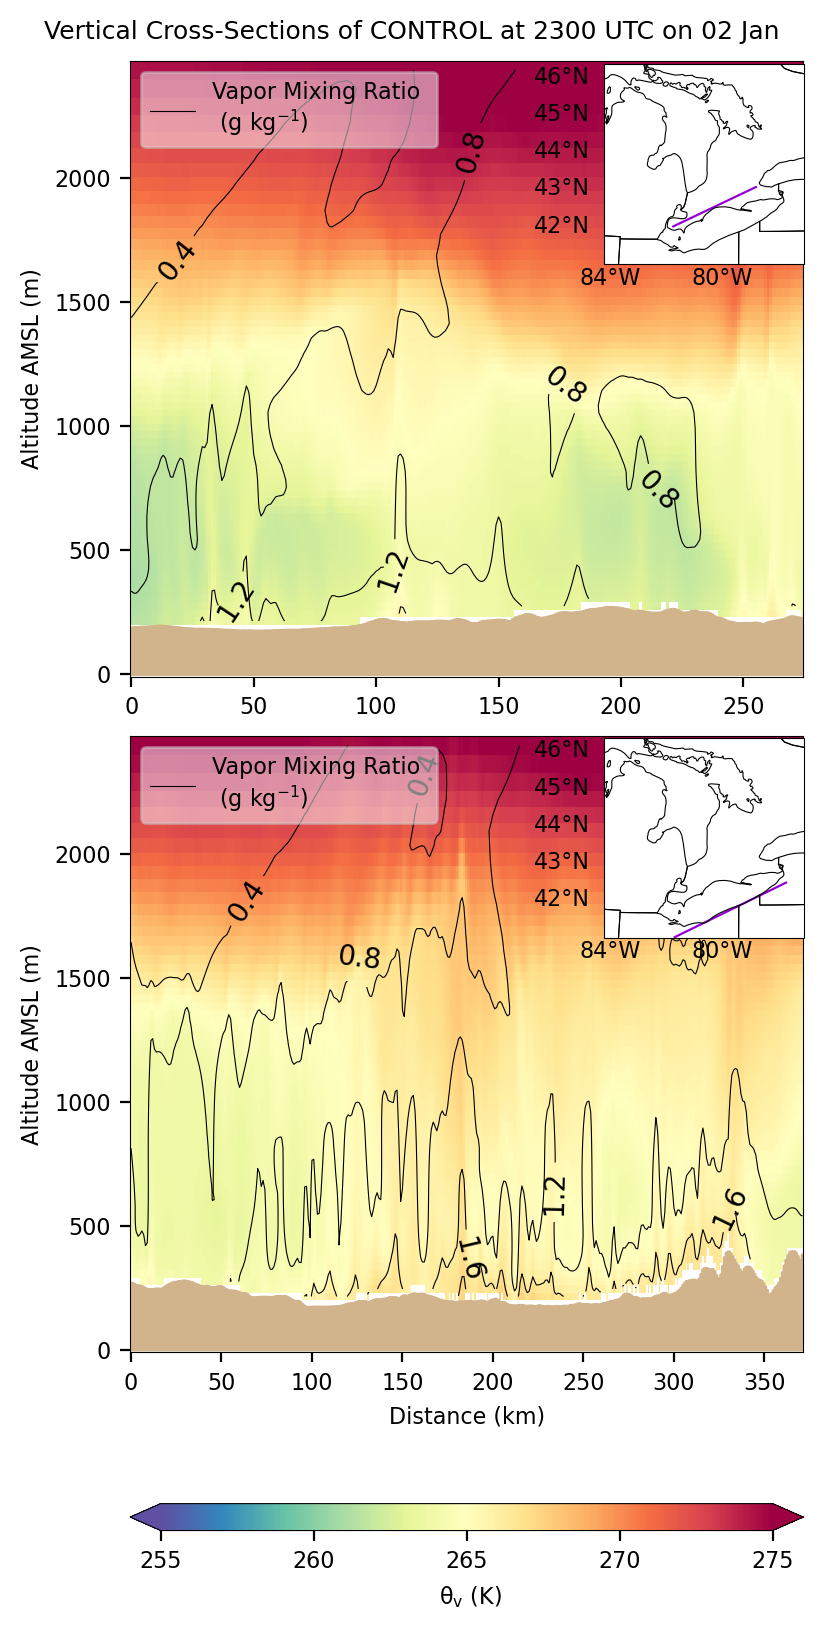

In [54]:
ftimedt = datetime.strptime(ftime, "%Y-%m-%d-%H%M%S")
ramscrs = ccrs.Stereographic(central_latitude = 42, central_longitude = -80)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (4,8), dpi = 200)
fig.suptitle(f"Vertical Cross-Sections of CONTROL at {ftimedt.strftime('%H%M')} UTC on {ftimedt.strftime('%d')} Jan", fontsize = 9)
tempmp = ax1.pcolormesh(controlcross1["index"], controlcross1["vertical"].sel(vertical = slice(0,2500)),
              controlcross1["Theta"].sel(vertical = slice(0,2500))*(1+0.61*controlcross1["VaporMix"].sel(vertical = slice(0,2500))/1000), cmap = "Spectral_r", vmin = 255, vmax = 275)
vapcon1 = ax1.contour(controlcross1["index"], controlcross1["vertical"].sel(vertical = slice(0,2500)),
            controlcross1["VaporMix"].sel(vertical = slice(0,2500)), levels = [0.4, 0.8, 1.2, 1.6, 2], colors = "black")
vapcon1.clabel(inline = True)
fakevapcon = Line2D([],[], color = "black", label = "Vapor Mixing Ratio \n ($\mathrm{g \ kg^{-1}}$)")
ax1.fill_between(controlcross1["index"], controlcross1["Topo"], np.zeros(len(controlcross1["index"])), color = "tan", step = "mid")
ax1.legend(handles = [fakevapcon], fontsize = 8, framealpha = 0.5, loc = "upper left")
ax1.set_ylabel("Altitude AMSL (m)")
ax_inset1 = fig.add_axes(rect = [0.74, 0.717, 0.25, 0.25], anchor = "NE", projection = ramscrs, zorder = 3)
ax_inset1 = add_cartofeatures_zoomdomain(ax_inset1)
ax_inset1.set_extent((controlgrid["x"][50], controlgrid["x"][650], controlgrid["y"][450], controlgrid["y"][1050]), crs = ramscrs)
ax_inset1.plot([lon11, lon12], [lat11, lat12], transform = ccrs.PlateCarree(), color = "darkviolet", linewidth = 0.8, linestyle = "-")
ax2.pcolormesh(controlcross2["index"], controlcross2["vertical"].sel(vertical = slice(0,2500)),
              controlcross2["Theta"].sel(vertical = slice(0,2500))*(1+0.61*controlcross2["VaporMix"].sel(vertical = slice(0,2500))/1000), cmap = "Spectral_r", vmin = 255, vmax = 275)
vapcon2 = ax2.contour(controlcross2["index"], controlcross2["vertical"].sel(vertical = slice(0,2500)),
            controlcross2["VaporMix"].sel(vertical = slice(0,2500)), levels = [0.4, 0.8, 1.2, 1.6, 2], colors = "black")
vapcon2.clabel(inline = True)
ax2.fill_between(controlcross2["index"], controlcross2["Topo"], np.zeros(len(controlcross2["index"])), color = "tan", step = "mid")
ax2.set_ylabel("Altitude AMSL (m)")
fig.colorbar(tempmp, ax = [ax1, ax2], ticks = [255, 260, 265, 270, 275], orientation = "horizontal", fraction = 0.15, aspect = 25, extend = "both", label = r" $\mathrm{\theta_v}$ (K)")
ax_inset2 = fig.add_axes([0.74, 0.296, 0.25, 0.25], anchor = "NE", projection = ramscrs, zorder = 2)
ax_inset2 = add_cartofeatures_zoomdomain(ax_inset2)
ax2.set_xlabel("Distance (km)")
ax2.legend(handles = [fakevapcon], fontsize = 8, framealpha = 0.5, loc = "upper left")
ax_inset2.plot([lon21, lon22], [lat21, lat22], transform = ccrs.PlateCarree(), color = "darkviolet", linewidth = 0.8, linestyle = "-")
# fig.savefig(f"../PaperFigs/supplemental_control_xctransects_{ftimedt.strftime('%d-%H%M')}z.png")

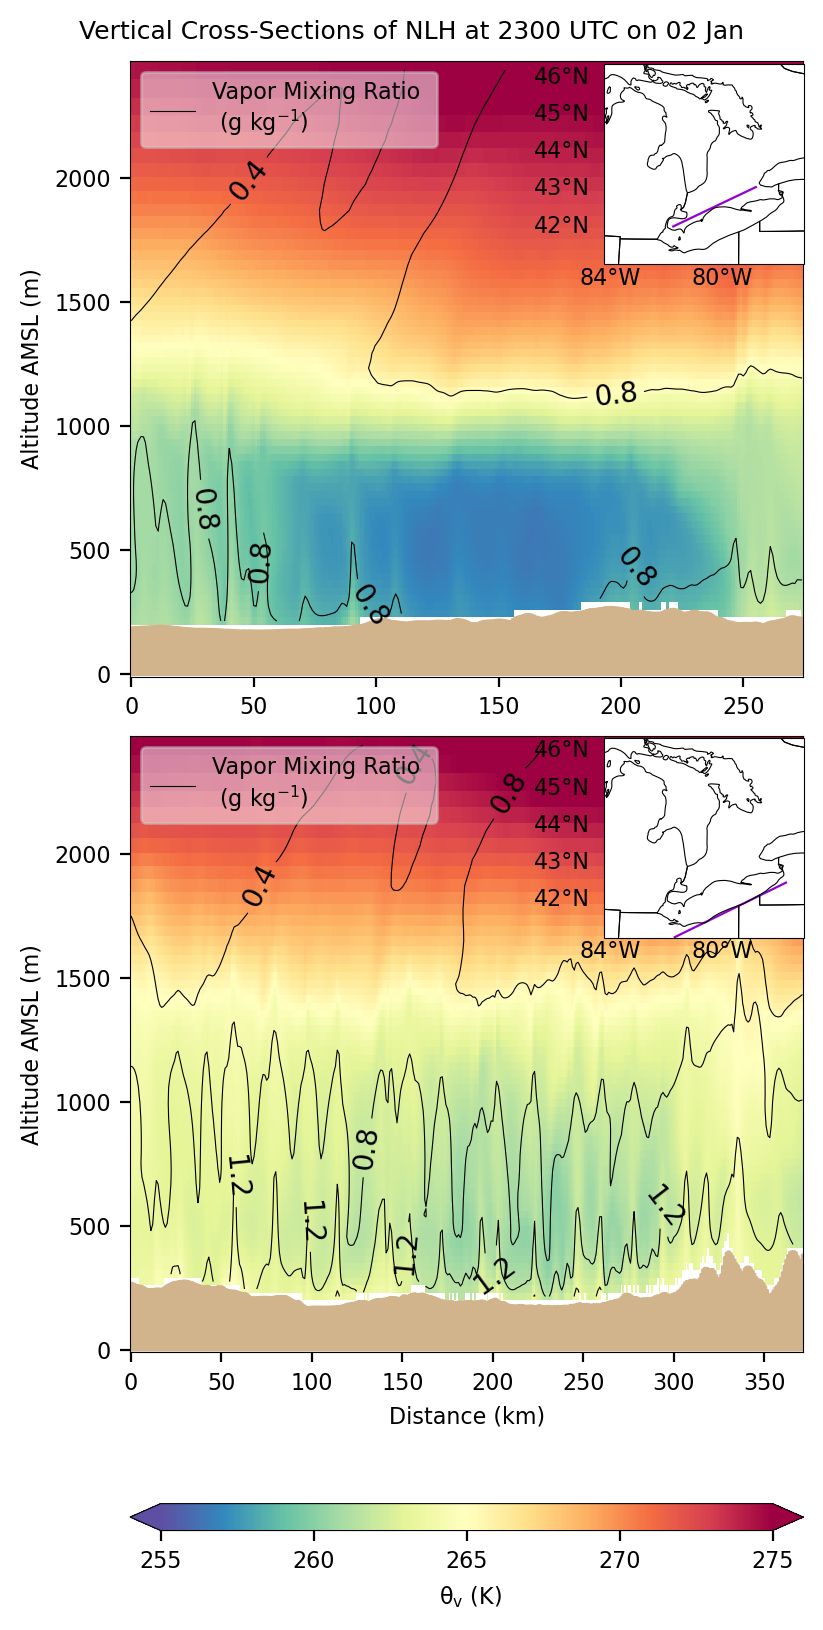

In [55]:
ramscrs = ccrs.Stereographic(central_latitude = 42, central_longitude = -80)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (4,8), dpi = 200)
fig.suptitle(f"Vertical Cross-Sections of NLH at {ftimedt.strftime('%H%M')} UTC on {ftimedt.strftime('%d')} Jan", fontsize = 9)
tempmp = ax1.pcolormesh(nlhcross1["index"], nlhcross1["vertical"].sel(vertical = slice(0,2500)),
              nlhcross1["Theta"].sel(vertical = slice(0,2500))*(1+0.61*nlhcross1["VaporMix"].sel(vertical = slice(0,2500))/1000), cmap = "Spectral_r", vmin = 255, vmax = 275)
vapcon1 = ax1.contour(nlhcross1["index"], nlhcross1["vertical"].sel(vertical = slice(0,2500)),
            nlhcross1["VaporMix"].sel(vertical = slice(0,2500)), levels = [0.4, 0.8, 1.2, 1.6, 2], colors = "black")
vapcon1.clabel(inline = True)
fakevapcon = Line2D([],[], color = "black", label = "Vapor Mixing Ratio \n ($\mathrm{g \ kg^{-1}}$)")
ax1.fill_between(controlcross1["index"], controlcross1["Topo"], np.zeros(len(controlcross1["index"])), color = "tan", step = "mid")
ax1.legend(handles = [fakevapcon], fontsize = 8, framealpha = 0.5, loc = "upper left")
ax1.set_ylabel("Altitude AMSL (m)")
ax_inset1 = fig.add_axes(rect = [0.74, 0.717, 0.25, 0.25], anchor = "NE", projection = ramscrs, zorder = 3)
ax_inset1 = add_cartofeatures_zoomdomain(ax_inset1)
ax_inset1.set_extent((nlhgrid["x"][50], nlhgrid["x"][650], nlhgrid["y"][450], nlhgrid["y"][1050]), crs = ramscrs)
ax_inset1.plot([lon11, lon12], [lat11, lat12], transform = ccrs.PlateCarree(), color = "darkviolet", linewidth = 0.8, linestyle = "-")
ax2.pcolormesh(nlhcross2["index"], nlhcross2["vertical"].sel(vertical = slice(0,2500)),
              nlhcross2["Theta"].sel(vertical = slice(0,2500))*(1+0.61*nlhcross2["VaporMix"].sel(vertical = slice(0,2500))/1000), cmap = "Spectral_r", vmin = 255, vmax = 275)
vapcon2 = ax2.contour(nlhcross2["index"], nlhcross2["vertical"].sel(vertical = slice(0,2500)),
            nlhcross2["VaporMix"].sel(vertical = slice(0,2500)), levels = [0.4, 0.8, 1.2, 1.6, 2], colors = "black")
vapcon2.clabel(inline = True)
ax2.fill_between(controlcross2["index"], controlcross2["Topo"], np.zeros(len(controlcross2["index"])), color = "tan", step = "mid")
ax2.set_ylabel("Altitude AMSL (m)")
fig.colorbar(tempmp, ax = [ax1, ax2], ticks = [255, 260, 265, 270, 275], orientation = "horizontal", fraction = 0.15, aspect = 25, extend = "both", label = r" $\mathrm{\theta_v}$ (K)")
ax2.legend(handles = [fakevapcon], fontsize = 8, framealpha = 0.5, loc = "upper left")
ax_inset2 = fig.add_axes([0.74, 0.296, 0.25, 0.25], anchor = "NE", projection = ramscrs, zorder = 2)
ax_inset2 = add_cartofeatures_zoomdomain(ax_inset2)
ax2.set_xlabel("Distance (km)")
ax_inset2.plot([lon21, lon22], [lat21, lat22], transform = ccrs.PlateCarree(), color = "darkviolet", linewidth = 0.8, linestyle = "-")
# fig.savefig(f"../PaperFigs/supplemental_nlh_xctransects_{ftimedt.strftime('%d-%H%M')}.png")

### Average Vertical Profiles of Temperature

Text(0.5, 1.0, 'Upwind Horizontal Average \n Temperature Profile at 2010-01-02-230000')

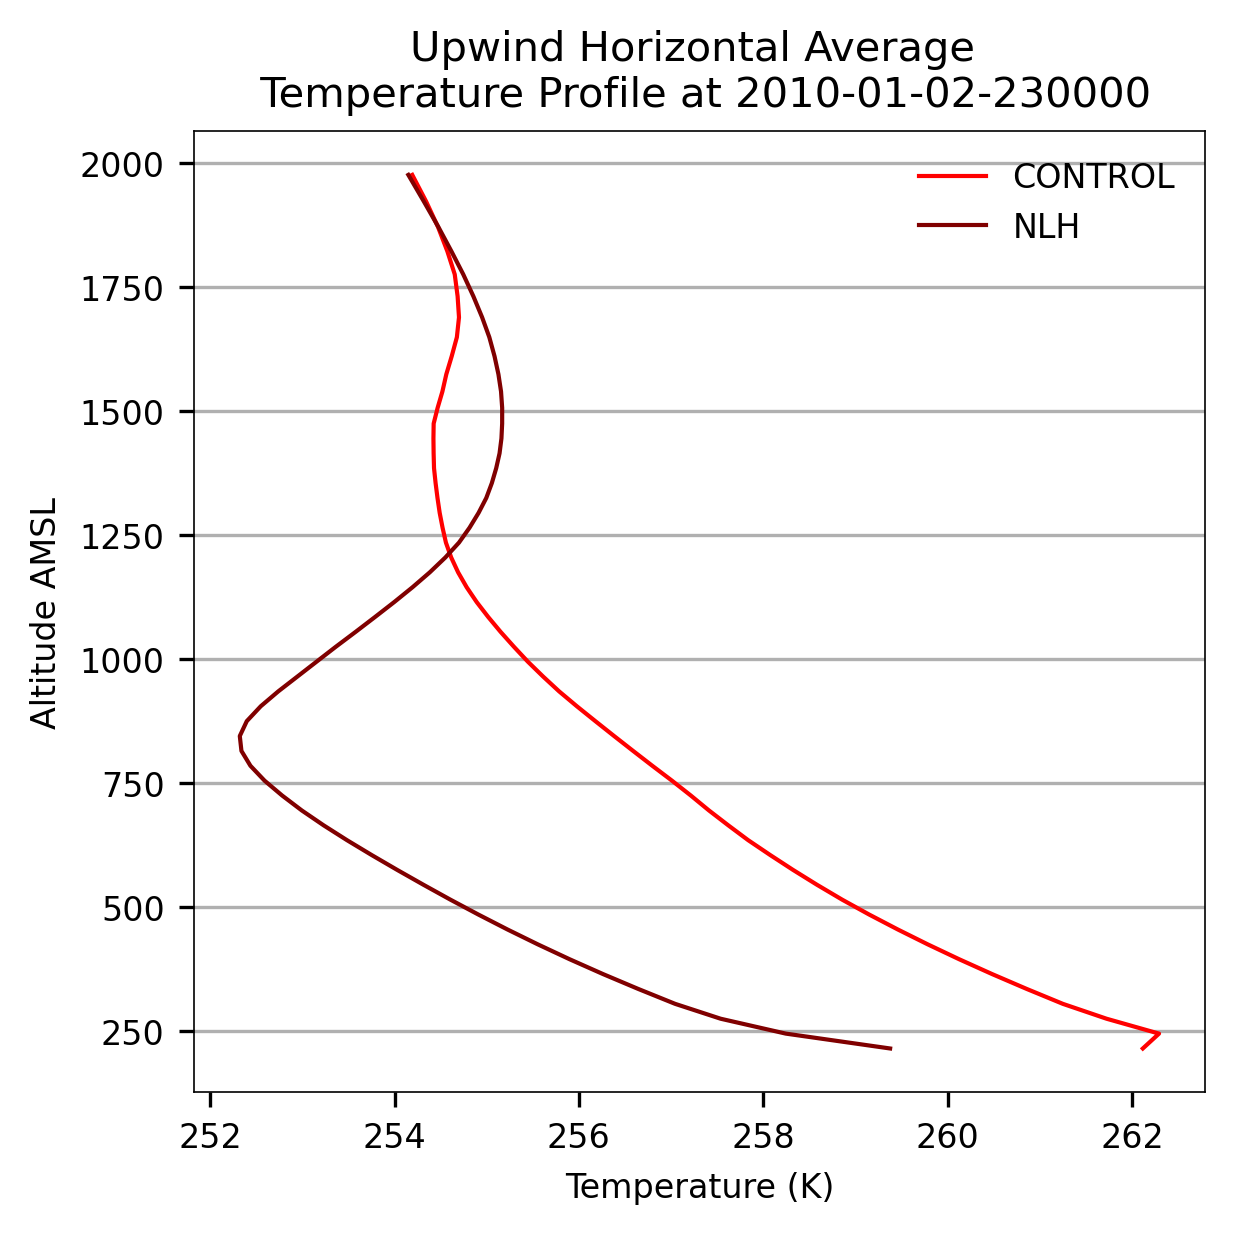

In [56]:
plt.figure(figsize = (4,4), dpi = 300)
plt.grid(axis = "y")
plt.xlabel("Temperature (K)")
plt.ylabel("Altitude AMSL")
plt.plot(controlcross1["Temperature"].mean(dim = "dist").sel(vertical = slice(0, 2000)), controlcross1["vertical"].sel(vertical = slice(0,2000)), color = "red", linewidth = 1, label = "CONTROL")
plt.plot(nlhcross1["Temperature"].mean(dim = "dist").sel(vertical = slice(0, 2000)), nlhcross1["vertical"].sel(vertical = slice(0, 2000)), color = "maroon", linewidth = 1, label = "NLH")
plt.legend()
plt.title(f"Upwind Horizontal Average \n Temperature Profile at {ftime}")

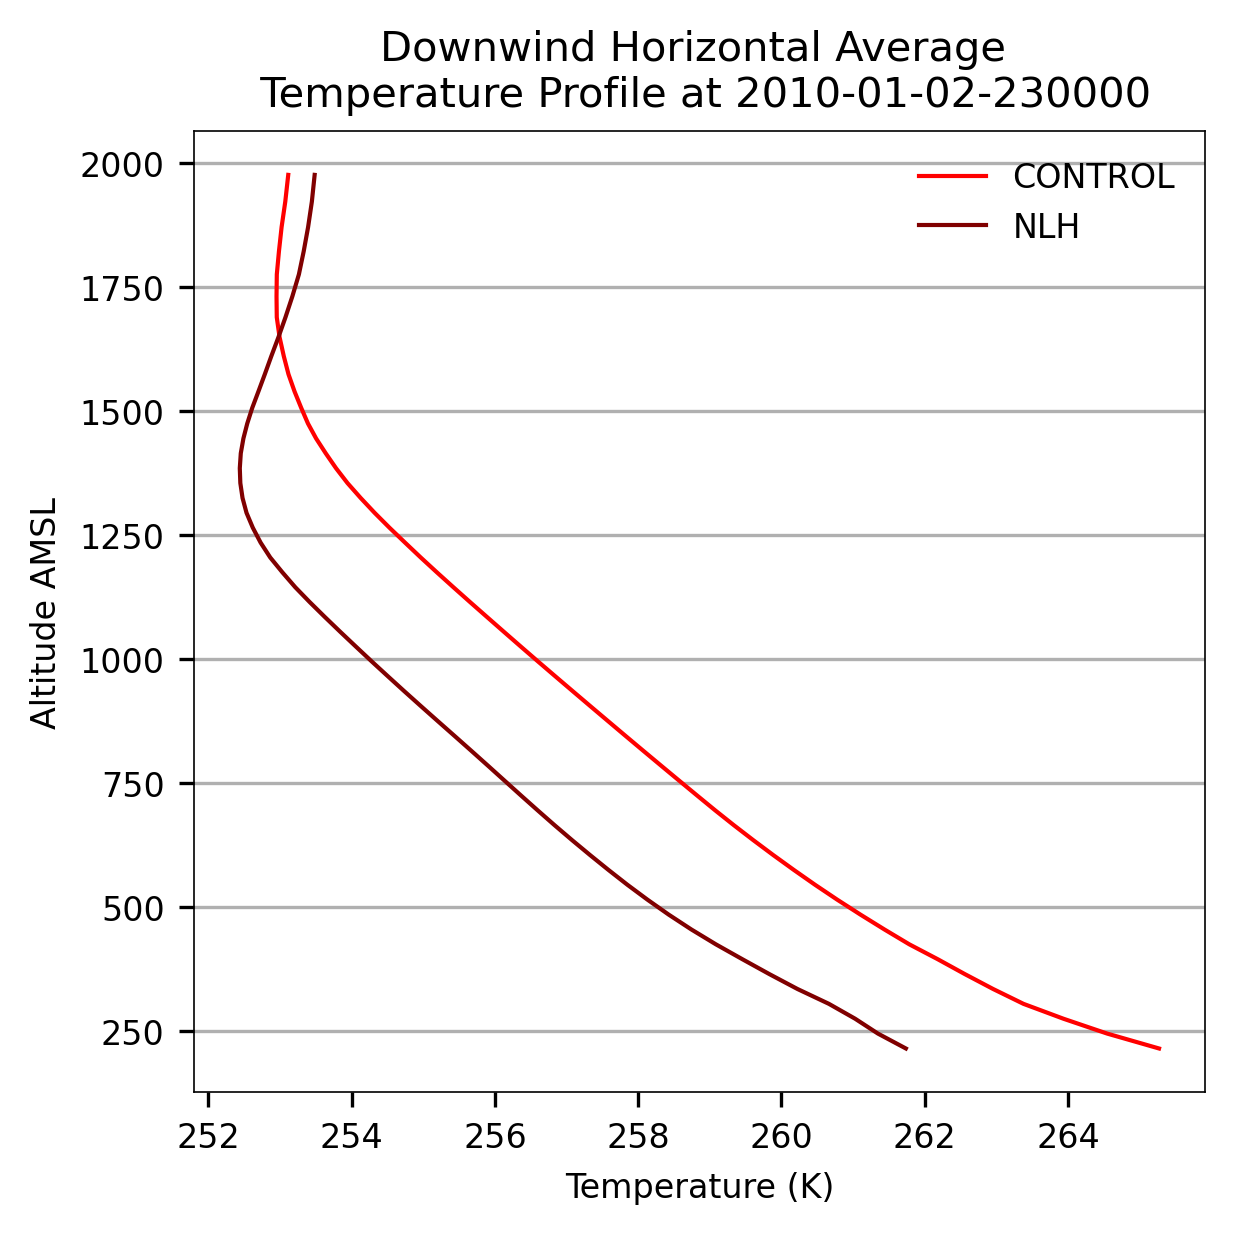

In [57]:
plt.figure(figsize = (4,4), dpi = 300)
plt.grid(axis = "y")
plt.xlabel("Temperature (K)")
plt.ylabel("Altitude AMSL")
plt.plot(controlcross2["Temperature"].mean(dim = "dist").sel(vertical = slice(0, 2000)), controlcross2["vertical"].sel(vertical = slice(0,2000)), color = "red", linewidth = 1, label = "CONTROL")
plt.plot(nlhcross2["Temperature"].mean(dim = "dist").sel(vertical = slice(0, 2000)), nlhcross2["vertical"].sel(vertical = slice(0, 2000)), color = "maroon", linewidth = 1, label = "NLH")
plt.title(f"Downwind Horizontal Average \n Temperature Profile at {ftime}")
plt.legend()

### Skew-T For Upwind and Downwind Transects

In [61]:
import metpy.calc as mcalc
from metpy.plots import SkewT
from metpy.units import units

ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
tfig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5.5), dpi = 300)
axlabels = ["(a)", "(b)"]
for ax in (ax1, ax2):
    ax.tick_params(bottom = False, top = False, left = False, right = False, labelbottom = False, labeltop = False, labelleft = False, labelright = False, labelsize = 10)
    ax.set_axis_off()
pltftime = datetime.strptime(ftime, "%Y-%m-%d-%H%M%S")
tempskew = SkewT(tfig, rotation = 45, subplot = (1, 2, 1))
dwptskew = SkewT(tfig, rotation = 45, subplot = (1, 2, 2))
for i, skewtax in enumerate((tempskew.ax, dwptskew.ax)):
    left, width = 0, 0.06
    bottom, height = 0.94, 0.06
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(skewtax.transAxes)
    p.set_clip_on(False)
    skewtax.add_patch(p)
    skewtax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = skewtax.transAxes, horizontalalignment = "center", verticalalignment = "center")
tempskew.ax.set_ylim(1050, 500); dwptskew.ax.set_ylim(1050, 500)
tempskew.ax.set_xlim(-20, 7); dwptskew.ax.set_xlim(-20, 7)
tempskew.ax.tick_params(labelsize = 8); dwptskew.ax.tick_params(labelsize = 10)

ax_inset1 = tfig.add_axes([0.269, 0.582, 0.3, 0.3], transform = tempskew.ax.transAxes, projection = ramscrs, zorder = 2)
ax_inset2 = tfig.add_axes([0.763, 0.582, 0.3, 0.3], transform = dwptskew.ax.transAxes, projection = ramscrs, zorder = 2)
ax_inset1 = add_cartofeatures_zoomdomain(ax_inset1)
ax_inset2 = add_cartofeatures_zoomdomain(ax_inset2)
ax_inset1.plot([lon11, lon12], [lat11, lat12], transform = ccrs.PlateCarree(), color = "darkviolet", linewidth = 0.8, linestyle = "-")
ax_inset1.plot([lon21, lon22], [lat21, lat22], transform = ccrs.PlateCarree(), color = "darkviolet", linewidth = 0.8, linestyle = "--")
ax_inset2.plot([lon11, lon12], [lat11, lat12], transform = ccrs.PlateCarree(), color = "darkviolet", linewidth = 0.8, linestyle = "-")
ax_inset2.plot([lon21, lon22], [lat21, lat22], transform = ccrs.PlateCarree(), color = "darkviolet", linewidth = 0.8, linestyle = "--")
contemp_upwind, = tempskew.plot(controlcross1["Pressure"].mean(dim = "dist")*units.hPa, controlcross1["Temperature"].mean(dim = "dist")*units.K-273.15*units.K, color = "red", label = "CONTROL Upwind \n Temperature", linestyle = "-", linewidth = 1)
contemp_downwind, = tempskew.plot(controlcross2["Pressure"].mean(dim = "dist")*units.hPa, controlcross2["Temperature"].mean(dim = "dist")*units.K-273.15*units.K, color = "red", label = "CONTROL Downwind \n Temperature", linestyle = "--", linewidth = 1)
contemp_avg, = tempskew.plot(eriethermo_control["Pressure"]*units.hPa, eriethermo_control["Temperature"]*units.K-273.15*units.K, color = "red", linestyle = ":", label = "CONTROL Lake-\nAverage Temperature", linewidth = 1)

condew_upwind, = dwptskew.plot(controlcross1["Pressure"].mean(dim = "dist")*units.hPa, controlcross1["Dewpoint"].mean(dim = "dist")*units.K-273.15*units.K, color = "dodgerblue", label = "CONTROL Upwind \n Dewpoint", linestyle = "-", linewidth = 1)
condew_downwind, = dwptskew.plot(controlcross2["Pressure"].mean(dim = "dist")*units.hPa, controlcross2["Dewpoint"].mean(dim = "dist")*units.K-273.15*units.K, color = "dodgerblue", label = "CONTROL Downwind \n Dewpoint", linestyle = "--", linewidth = 1)
condew_avg, = dwptskew.plot(eriethermo_control["Pressure"]*units.hPa, eriethermo_control["Dewpoint"]*units.K-273.15*units.K, color = "dodgerblue", linestyle = ":", label = "CONTROL Lake-\nAverage Dewpoint", linewidth = 1)

nlhtemp_upwind, = tempskew.plot(nlhcross1["Pressure"].mean(dim = "dist")*units.hPa, nlhcross1["Temperature"].mean(dim = "dist")*units.K-273.15*units.K, color = "maroon", label = "NLH Upwind \n Temperature", linestyle = "-", linewidth = 1)
nlhtemp_downwind, = tempskew.plot(nlhcross2["Pressure"].mean(dim = "dist")*units.hPa, nlhcross2["Temperature"].mean(dim = "dist")*units.K-273.15*units.K, color = "maroon", label = "NLH Downwind \n Temperature", linestyle = "--", linewidth = 1)
nlhtemp_avg, = tempskew.plot(eriethermo_nolake["Pressure"]*units.hPa, eriethermo_nolake["Temperature"]*units.K-273.15*units.K, color = "maroon", linestyle = ":", label = "NLH Lake-\nAverage Temperature", linewidth = 1)

nlhdew_upwind, = dwptskew.plot(nlhcross1["Pressure"].mean(dim = "dist")*units.hPa, nlhcross1["Dewpoint"].mean(dim = "dist")*units.K-273.15*units.K, color = "midnightblue", label = "NLH Upwind \n Dewpoint", linestyle = "-", linewidth = 1)
nlhdew_downwind, = dwptskew.plot(nlhcross2["Pressure"].mean(dim = "dist")*units.hPa, nlhcross2["Dewpoint"].mean(dim = "dist")*units.K-273.15*units.K, color = "midnightblue", label = "NLH Downwind \n Dewpoint", linestyle = "--", linewidth = 1)
nlhdew_avg, = dwptskew.plot(eriethermo_nolake["Pressure"]*units.hPa, eriethermo_nolake["Dewpoint"]*units.K-273.15*units.K, color = "midnightblue", linestyle = ":", label = "NLH Lake-\nAverage Dewpoint", linewidth = 1) 
proflegendtemp = tempskew.ax.legend(framealpha = 1, fontsize = 10, loc = "center right", handles = [contemp_upwind, contemp_downwind, contemp_avg, nlhtemp_upwind, nlhtemp_downwind, nlhtemp_avg], bbox_to_anchor = (1.015, 0.29))
proflegenddew = dwptskew.ax.legend(framealpha = 1, fontsize = 10, loc = "center right", handles = [condew_upwind, condew_downwind, condew_avg, nlhdew_upwind, nlhdew_downwind, nlhdew_avg], bbox_to_anchor = (1.015, 0.29))
tempskew.ax.add_artist(proflegendtemp)
dwptskew.ax.add_artist(proflegenddew)
tempskew.ax.set_title("Temperature Comparison", fontsize = 12)
dwptskew.ax.set_title("Dewpoint Comparison", fontsize = 12)
tempskew.ax.set_ylabel("Pressure (hPa)", fontsize = 12)
tempskew.ax.set_xlabel(r"Temperature ($\mathrm{\degree C}$)", fontsize = 12)
dwptskew.ax.set_xlabel(r"Dewpoint ($\mathrm{\degree C}$)", fontsize = 12)
tfig.savefig(f"../PaperFigs/skewt_transects_{datetime.strptime(ftime, '%Y-%m-%d-%H%M%S').strftime('%d-%H%M')}z_2panel.png")
plt.close();
del tfig; del ax_inset1; del ax_inset2
del tempskew; del dwptskew; del ax1; del ax2

In [62]:
mean_controltemp = controlcross1["Temperature"].mean(dim = "dist")
mean_nlhtemp = nlhcross1["Temperature"].mean(dim = "dist")
control_pblbot = np.argwhere(np.logical_not(np.isnan(mean_controltemp.values)))[1,0]; print(control_pblbot)
nlh_pblbot = np.argwhere(np.logical_not(np.isnan(mean_nlhtemp.values))).min(); print(nlh_pblbot)
control_pbltop = np.argwhere(np.diff(controlcross1["Temperature"].mean(dim = "dist").values) > 0)[1,0] #1 instead of .min() because the very lowest model level has a small inversion
print(control_pbltop)
nlh_pbltop = np.argwhere(np.diff(nlhcross1["Temperature"].mean(dim = "dist").values) > 0).min()

lowlapse_control = -1000 * (mean_controltemp.isel(vertical = control_pblbot + 10) - mean_controltemp.isel(vertical = control_pblbot)) / (controlcross1["vertical"].isel(vertical = control_pblbot + 10) - controlcross1["vertical"].isel(vertical = control_pblbot))
lowlapse_nlh = -1000 * (mean_nlhtemp.isel(vertical = nlh_pblbot + 10) - mean_nlhtemp.isel(vertical = nlh_pblbot)) / (controlcross1["vertical"].isel(vertical = nlh_pblbot + 10) - controlcross1["vertical"].isel(vertical = nlh_pblbot))

#don't need to change the vertical indexing between CONTROL and NLH, because they're on the same grid.

print(f"Lapse rate in the lowest 300 m along a transect just upwind of Lake Erie in CONTROL: {lowlapse_control:.2f} K / km. Along the same transect in NLH, the lapse rate in the lowest 300 m is {lowlapse_nlh:.2f} K / km")

parcelprof_control = mcalc.parcel_profile(controlcross1["Pressure"].mean(dim = "dist").isel(vertical = slice(control_pblbot, control_pbltop)).values*units.hPa, controlcross1["Temperature"].mean(dim = "dist").isel(vertical = control_pblbot).values*units.K, controlcross1["Dewpoint"].mean(dim = "dist").isel(vertical = control_pblbot).values*units.K)

parcelprof_nlh = mcalc.parcel_profile(nlhcross1["Pressure"].mean(dim = "dist").isel(vertical = slice(nlh_pblbot, nlh_pbltop)).values*units.hPa, nlhcross1["Temperature"].mean(dim = "dist").isel(vertical = nlh_pblbot).values*units.K, nlhcross1["Dewpoint"].mean(dim = "dist").isel(vertical = nlh_pblbot).values*units.K)

cape_control = mcalc.cape_cin(controlcross1["Pressure"].mean(dim = "dist").isel(vertical = slice(control_pblbot, control_pbltop)).values*units.hPa, controlcross1["Temperature"].mean(dim = "dist").isel(vertical = slice(control_pblbot, control_pbltop)).values*units.K, controlcross1["Dewpoint"].mean(dim = "dist").isel(vertical = slice(control_pblbot, control_pbltop)).values*units.K, parcelprof_control)

cape_nlh = mcalc.cape_cin(nlhcross1["Pressure"].mean(dim = "dist").isel(vertical = slice(nlh_pblbot, nlh_pbltop)).values*units.hPa, nlhcross1["Temperature"].mean(dim = "dist").isel(vertical = slice(nlh_pblbot, nlh_pbltop)).values*units.K, nlhcross1["Dewpoint"].mean(dim = "dist").isel(vertical = slice(nlh_pblbot, nlh_pbltop)).values*units.K, parcelprof_nlh)

print(f"CAPE in surface layer of CONTROL: {cape_control[0]:.2f}. CAPE in surface layer of NLH: {cape_nlh[0]:.2f}")

8
7
48
Lapse rate in the lowest 300 m along a transect just upwind of Lake Erie in CONTROL: 12.37 K / km. Along the same transect in NLH, the lapse rate in the lowest 300 m is 15.90 K / km
CAPE in surface layer of CONTROL: 1.11 joule / kilogram. CAPE in surface layer of NLH: 3.03 joule / kilogram


In [63]:
controlthermo.close(); del controlthermo
nolakethermo.close(); del nolakethermo
controlcross1.close(); del controlcross1
controlcross2.close(); del controlcross2
nlhcross1.close(); del nlhcross1
nlhcross2.close(); del nlhcross2

## Figure showing locations of vertical cross-sections 1

In [64]:
ix0s = [280, 310, 370, 385] #Southwest x points of the cross-sections
iy0s = [690, 600, 520, 500] #Southwest y points of the cross-sections
#These points were picked subjectively based on the 700 m vertical velocity field
angles = [30, 30, 50, 25] #Angle north of east of each cross-section
lengths = [100000, 100000, 100000, 100000] #Lengths, in m, of the cross-sections
xcdict = {}
xcnames = ["LH", "OP", "LE", "AP"] #Names of the cross sections. These mean "Lake Huron", "Ontario Peninsula", "Lake Erie", and "Allegheny Plateau", respectively
xclabels = {"LH": "1", "OP": "2", "LE": "3", "AP": "4"} #I realized that it's probably better to just number the cross-sections instead of using the 2-letter labeling
for i,_ in enumerate(ix0s):
    ix0 = ix0s[i]
    iy0 = iy0s[i]
    angle = angles[i]
    length = lengths[i]
    x0 = controlgrid["x"].isel(x = ix0); y0 = controlgrid["y"].isel(y = iy0); dxy = np.diff(controlgrid["x"])[0]
    darray = np.arange(0, length+1, dxy);  #Coordinates of the box in distance along the cross-section. Positive is to the northeast
    angle = np.pi/180*(angle) #Angle of the long axis of the box, with respect to the horizontal
    xbox = x0.values+np.cos(angle)*darray
    ybox = y0.values+np.sin(angle)*darray
    xcset = xr.DataArray(coords = {"y": ("distance", ybox), "x": ("distance", xbox), "distance": darray}, dims = ["distance"])
    xcdict[xcnames[i]] = xcset

In [67]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
walt = 700
xclabels = {"LH": "1", "OP": "2", "LE": "3", "AP": "4"}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 3.2), dpi = 200, layout = "constrained", subplot_kw = {"projection": ramscrs})
fig.get_layout_engine().set(wspace = 0, hspace = 0, w_pad = 4/72, h_pad = 4/72)
axlabels = ["(a)", "(b)"]
for i, ax in enumerate([ax1, ax2]):
    ax = add_cartofeatures_zoomdomain(ax)
    left, width = 0, 0.10
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
for xcname in xcnames[:3]:
    ax1.plot([xcdict[xcname]["x"][0], xcdict[xcname]["x"][-1]], [xcdict[xcname]["y"][0], xcdict[xcname]["y"][-1]], linewidth = 0.5, color = "black", zorder = 2)
    ax1.annotate(xclabels[xcname], xy = (xcdict[xcname]["x"][-1]+5000, xcdict[xcname]["y"][-1]-8000), horizontalalignment = "left", color = "black", fontsize = 8)
walt = 700 #m AMSL, altitude at which to evalute w
wmp = ax1.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(400, 1050)), afile_control_onetime["w"].sel(z = walt, method = "nearest").isel(x = slice(50, 650), y = slice(400, 1050)), cmap = "RdBu_r", vmin = -3, vmax = 3, zorder = 1, transform = ramscrs)
ax2.pcolormesh(controlgrid["x"].isel(x = slice(50, 650)), controlgrid["y"].isel(y = slice(400, 1050)), afile_nolake_onetime["w"].sel(z = walt, method = "nearest").isel(x = slice(50, 650), y = slice(400, 1050)), cmap = "RdBu_r", vmin = -3, vmax = 3, zorder = 1, transform = ramscrs)
ax1.set_title("CONTROL", fontsize = 12)
ax2.set_title("NLH", fontsize = 12)
cbar = fig.colorbar(wmp, ax = [ax1, ax2], orientation = "horizontal", fraction = 0.05, extend = "both", aspect = 30); cbar.set_label(f"{walt}-m AMSL Vertical Velocity ($\mathrm{{m \ s^{{-1}}}}$)", fontsize = 10)
fig.savefig("../PaperFigs/wcomp_xcmark.png")
plt.close(); 
del fig; del ax1; del ax2;

In [69]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
# print("Plotting field Div")
# print(ftime)
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128) #A truncated version of gist_earth to only show terrain height above sea level (gets rid of all the blue on the colorbar)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (5, 5.5), dpi = 200, layout = "compressed", subplot_kw = {"projection": ramscrs})
axlabels = ["(a)", "(b)", "(c)", "(d)"]
fakecontour = Line2D([], [], color = "black", linewidth = 0.375, label = "Water Bodies")
for i, ax in enumerate(fig.get_axes()):
    ax = add_cartofeatures_zoomdomain(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center", zorder = 5, color = "black")
    tercmap = ax.pcolormesh(afile_control_onetime["x"][50:650], afile_control_onetime["y"][450:1050], afile_control_onetime["Topo"][450:1050, 50:650], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)
divalt1 = 350 #m AMSL, altitude at which to evaluate horizontal divergence on bottom row of plots.
divalt2 = 1500 #m AMSL, altitude at which to evaluate horizontal divergence on top row of plot
# fig.suptitle(f"Horizontal Divergence at {time2300z.strftime('%d')} Jan - {time2300z.strftime('%H%M')} UTC")
ax1.set_title(f"CONTROL {divalt1}m")
ax2.set_title(f"NLH {divalt1}m")
ax3.set_title(f"CONTROL {divalt2}m")
ax4.set_title(f"NLH {divalt2}m")
for xcname in xcnames[:3]:
    ax1.plot([xcdict[xcname]["x"][0], xcdict[xcname]["x"][-1]], [xcdict[xcname]["y"][0], xcdict[xcname]["y"][-1]], linewidth = 0.5, color = "black", zorder = 2)
    ax1.annotate(xclabels[xcname], xy = (xcdict[xcname]["x"][-1]+5000, xcdict[xcname]["y"][-1]-8000), horizontalalignment = "left", color = "black", fontsize = 8)
divmp = ax1.pcolormesh(afile_control_onetime["x"].isel(x = slice(50, 650)), afile_control_onetime["y"].isel(y = slice(450, 1050)), afile_control_onetime["HorizDiv"].isel(x = slice(50, 650), y = slice(450, 1050)).sel(z = divalt1, method = "nearest"), cmap = "BrBG", vmin = -5*10**(-3), vmax = 5*10**(-3), zorder = 1, transform = ramscrs)
ax2.pcolormesh(afile_control_onetime["x"].isel(x = slice(50, 650)), afile_control_onetime["y"].isel(y = slice(450, 1050)), afile_nolake_onetime["HorizDiv"].isel(x = slice(50, 650), y = slice(450, 1050)).sel(z = divalt1, method = "nearest"), cmap = "BrBG", vmin = -5*10**(-3), vmax = 5*10**(-3), zorder = 1, transform = ramscrs)
ax3.pcolormesh(afile_control_onetime["x"].isel(x = slice(50, 650)), afile_control_onetime["y"].isel(y = slice(450, 1050)), afile_control_onetime["HorizDiv"].isel(x = slice(50, 650), y = slice(450, 1050)).sel(z = divalt2, method = "nearest"), cmap = "BrBG", vmin = -5*10**(-3), vmax = 5*10**(-3), zorder = 1, transform = ramscrs)
ax4.pcolormesh(afile_control_onetime["x"].isel(x = slice(50, 650)), afile_control_onetime["y"].isel(y = slice(450, 1050)), afile_nolake_onetime["HorizDiv"].isel(x = slice(50, 650), y = slice(450, 1050)).sel(z = divalt2, method = "nearest"), cmap = "BrBG", vmin = -5*10**(-3), vmax = 5*10**(-3), zorder = 1, transform = ramscrs)
cbar1 = fig.colorbar(divmp, ax = [ax1, ax2, ax3, ax4], orientation = "horizontal", fraction = 0.05, aspect = 40, extend = "both", pad = 0.02); cbar1.set_label("Horizontal Divergence ($\mathrm{{s^{{-1}}}}$)", labelpad = 7)
cbar2 = fig.colorbar(tercmap, ax = [ax1, ax2, ax3, ax4], orientation = "vertical", location = "left", fraction = 0.05, aspect = 40, extend = "max", pad = 0.02); cbar2.set_label("Terrain height (m)", labelpad = 4)
cbar1.formatter.set_powerlimits((-1, 1))
fig.savefig(f"../PaperFigs/divcomp_xcmark.png")
plt.close();
del fig; del ax1; del ax2; del ax3; del ax4
del cbar1; del cbar2

## Plot vertical cross-sections of vertical velocity and horizontal divergence

In [70]:
lhdata = afile_control_onetime[["PatchArea", "Topo", "HorizDiv", "Temperature", "LatentHeatFreezingTotal", "ThetaV", "LatentHeatCondensationTotal", "VaporMix", "u", "v", "w", "SensibleHeatFlux"]].interp(x = xcdict["LH"]["x"], y = xcdict["LH"]["y"])
lhtanwind = lhdata["u"]*np.cos(np.pi/180*angles[0])+lhdata["v"]*np.sin(np.pi/180*angles[0])
opdata = afile_control_onetime[["PatchArea", "Topo", "HorizDiv", "Temperature", "LatentHeatFreezingTotal", "ThetaV", "LatentHeatCondensationTotal", "VaporMix", "u", "v", "w", "SensibleHeatFlux"]].interp(x = xcdict["OP"]["x"], y = xcdict["OP"]["y"])
optanwind = opdata["u"]*np.cos(np.pi/180*angles[1])+opdata["v"]*np.sin(np.pi/180*angles[1])
ledata = afile_control_onetime[["PatchArea", "Topo", "HorizDiv", "Temperature", "LatentHeatFreezingTotal", "ThetaV", "LatentHeatCondensationTotal", "VaporMix", "u", "v", "w", "SensibleHeatFlux"]].interp(x = xcdict["LE"]["x"], y = xcdict["LE"]["y"])
letanwind = ledata["u"]*np.cos(np.pi/180*angles[2])+ledata["v"]*np.sin(np.pi/180*angles[2])
apdata = afile_control_onetime[["PatchArea", "Topo", "HorizDiv", "Temperature", "LatentHeatFreezingTotal", "ThetaV", "LatentHeatCondensationTotal", "VaporMix", "u", "v", "w", "SensibleHeatFlux"]].interp(x = xcdict["AP"]["x"], y = xcdict["AP"]["y"])
aptanwind = apdata["u"]*np.cos(np.pi/180*angles[3])+apdata["v"]*np.sin(np.pi/180*angles[3])

#Here, we calculate the wind speeds parallel to the direction of each cross-section, for use in the plots below

In [72]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, ((ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(3, 2, figsize = (6, 6.5), dpi = 200, layout = "constrained")
fig.get_layout_engine().set(hspace = 0, wspace = 0)
axlabels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]
for i, ax in enumerate(fig.get_axes()):
    left, width = 0, 0.10
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 9, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
for ax in (ax21, ax22, ax31, ax32, ax41, ax42):
    if ax in (ax22, ax32):
        #Don't include any axis labels for these panels
        ax.tick_params(bottom = False, top = False, left = False, right = False, labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    elif ax in (ax21, ax31):
        #Include y axis ticks
        ax.tick_params(bottom = False, top = False, left = True, right = False, labelbottom = False, labeltop = False, labelleft = True, labelright = False, labelsize = 10)
        ax.set_yticks(ticks = [0,500,1000,1500])
    elif ax is ax42:
        #Include x axis ticks
        ax.tick_params(bottom = True, top = False, left = False, right = False, labelbottom = True, labeltop = False, labelleft = False, labelright = False, labelsize = 10)
        ax.set_xticks(ticks = [0, 50000, 100000], labels = [0, 50, 100])
    elif ax is ax41:
        #Include both x and y axis ticks
        ax.tick_params(bottom = True, top = False, left = True, right = False, labelbottom = True, labeltop = False, labelleft = True, labelright = False, labelsize = 10)
        ax.set_xticks(ticks = [0, 50000, 100000], labels = [0, 50, 100])
        ax.set_yticks(ticks = [0, 500, 1000, 15000])
    ax.set_aspect(30)
    ax.set_ylim(0, 1900)
ax41.set_xlabel("Distance (km) ", fontsize = 10)
ax31.set_ylabel("Altitude (m)", fontsize = 10)
ax21.set_title("CS 1 Vertical Velocity", fontsize = 12)
wmp = ax21.pcolormesh(lhdata["distance"], lhdata["z"].sel(z = slice(0, 2000)), lhdata["w"].sel(z = slice(0, 2000)), vmin = -3, vmax = 3, cmap = "RdBu_r")
qvmp = ax21.quiver(lhdata["distance"][1::3], lhdata["z"][0:60:4], convolve(lhtanwind[0:60,:], kernel = np.array([[1,2,3,2,1], [1,2,3,2,1], [1,2,3,2,1]]), normalize_kernel = True, nan_treatment = "interpolate", preserve_nan = True)[::4,1::3]-lhtanwind[0:60:4,1::3].mean(dim = "distance").values[:,None], lhdata["w"][0:60:4,1::3]*10, headwidth = 5, headlength = 5)
left, width = 0.68, 0.32
bottom, height = 0.85, 0.15
right = left + width
top = bottom + height
p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 1, edgecolor = "black", linewidth = 0.2, facecolor = "white")
p.set_transform(ax21.transAxes)
p.set_clip_on(False)
ax21.add_patch(p)
ax21.quiverkey(qvmp, U = 5, X = 0.73, Y = 0.92, label = r"5 $m \ s^{-1}$", labelpos = "E")
ax21.fill_between(lhdata["distance"], lhdata["Topo"], np.zeros(len(lhdata["distance"])), color = "tan")
ax21.fill_between(lhdata["distance"].where(lhdata["PatchArea"][0,:] > 0.99), lhdata["Topo"].where(lhdata["PatchArea"][0,:]>0.99), 1/2*lhdata["Topo"].where(lhdata["PatchArea"][0,:]>0.99), color = "blue")
ax22.set_title("CS 1 Divergence", fontsize = 12)
divmp = ax22.pcolormesh(lhdata["distance"], lhdata["z"].sel(z = slice(0, 2000)), lhdata["HorizDiv"].sel(z = slice(0, 2000)), vmin = -5*10**(-3), vmax = 5*10**(-3), cmap = "BrBG", zorder = 0)
ax22.fill_between(lhdata["distance"], lhdata["Topo"], np.zeros(len(lhdata["distance"])), color = "tan", zorder = 1)
ax22.fill_between(lhdata["distance"].where(lhdata["PatchArea"][0,:] > 0.99), lhdata["Topo"].where(lhdata["PatchArea"][0,:]>0.99), 1/2*lhdata["Topo"].where(lhdata["PatchArea"][0,:]>0.99), color = "blue")
ax22.contour(lhdata["distance"], lhdata["z"][0:60], 3*lhdata["LatentHeatCondensationTotal"][0:60,:]+3*lhdata["LatentHeatCondensationTotal"][0:60,:], levels = [2, 5, 10], colors = "red", linestyles = "--")
thetamp1 = ax22.contour(lhdata["distance"], lhdata["z"][0:60], lhdata["ThetaV"][0:60,:], levels = np.arange(260, 275), cmap = "spring")
thetamp1.clabel(thetamp1.levels[::2], fontsize = 6, inline = True, fmt = lambda x: f"{x} K")
fakecontour = Line2D([], [], color = "red", linestyle = "--", linewidth = 1, label = r"Latent Heating Rate ($\mathrm{K \ hr^{-1}}$)")

ax31.set_title("CS 2 Vertical Velocity", fontsize = 12)
ax31.pcolormesh(opdata["distance"], opdata["z"].sel(z = slice(0, 2000)), opdata["w"].sel(z = slice(0, 2000)), vmin = -3, vmax = 3, cmap = "RdBu_r")
ax31.quiver(opdata["distance"][1::3], opdata["z"][0:60:4], convolve(optanwind[0:60,:], kernel = np.array([[1,2,3,2,1], [1,2,3,2,1], [1,2,3,2,1]]), normalize_kernel = True, nan_treatment = "interpolate", preserve_nan = True)[::4,1::3]-optanwind[0:60:4,1::3].mean(dim = "distance").values[:,None], opdata["w"][0:60:4,1::3]*10, headwidth = 5, headlength = 5)
ax31.fill_between(opdata["distance"], opdata["Topo"], np.zeros(len(opdata["distance"])), color = "tan")
ax31.fill_between(opdata["distance"].where(opdata["PatchArea"][0,:] > 0.99), opdata["Topo"].where(opdata["PatchArea"][0,:]>0.99), 1/2*opdata["Topo"].where(opdata["PatchArea"][0,:]>0.99), color = "blue")
ax32.set_title("CS 2 Divergence", fontsize = 12)
ax32.pcolormesh(opdata["distance"], opdata["z"].sel(z = slice(0, 2000)), opdata["HorizDiv"].sel(z = slice(0, 2000)), vmin = -5*10**(-3), vmax = 5*10**(-3), cmap = "BrBG", zorder = 0)
ax32.fill_between(opdata["distance"], opdata["Topo"], np.zeros(len(opdata["distance"])), color = "tan", zorder = 1)
ax32.fill_between(opdata["distance"].where(opdata["PatchArea"][0,:] > 0.99), opdata["Topo"].where(opdata["PatchArea"][0,:]>0.99), 1/2*opdata["Topo"].where(opdata["PatchArea"][0,:]>0.99), color = "blue")
ax32.contour(opdata["distance"], opdata["z"][0:60], 3*opdata["LatentHeatCondensationTotal"][0:60,:]+3*opdata["LatentHeatCondensationTotal"][0:60,:], levels = [2, 5, 10], colors = "red", linestyles = "--")
thetamp2 = ax32.contour(opdata["distance"], opdata["z"][0:60], opdata["ThetaV"][0:60,:], levels = np.arange(260, 275), cmap = "spring")
thetamp2.clabel(thetamp2.levels[::2], fontsize = 6, inline = True, fmt = lambda x: f"{x} K")

ax41.set_title("CS 3 Vertical Velocity", fontsize = 12)
ax41.pcolormesh(ledata["distance"], ledata["z"].sel(z = slice(0, 2000)), ledata["w"].sel(z = slice(0, 2000)), vmin = -3, vmax = 3, cmap = "RdBu_r")
ax41.quiver(ledata["distance"][1::3], ledata["z"][0:60:4], convolve(letanwind[0:60,:], kernel = np.array([[1,2,3,2,1], [1,2,3,2,1], [1,2,3,2,1]]), normalize_kernel = True, nan_treatment = "interpolate", preserve_nan = True)[::4,1::3]-letanwind[0:60:4,1::3].mean(dim = "distance").values[:,None], ledata["w"][0:60:4,1::3]*10, headwidth = 5, headlength = 5)
ax41.fill_between(ledata["distance"], ledata["Topo"], np.zeros(len(ledata["distance"])), color = "tan")
ax41.fill_between(ledata["distance"].where(ledata["PatchArea"][0,:] > 0.99), ledata["Topo"].where(ledata["PatchArea"][0,:]>0.99), 1/2*ledata["Topo"].where(ledata["PatchArea"][0,:]>0.99), color = "blue")
ax42.set_title("CS 3 Divergence", fontsize = 12)
ax42.pcolormesh(ledata["distance"], ledata["z"].sel(z = slice(0, 2000)), ledata["HorizDiv"].sel(z = slice(0, 2000)), vmin = -5*10**(-3), vmax = 5*10**(-3), cmap = "BrBG", zorder = 0)
ax42.fill_between(ledata["distance"], ledata["Topo"], np.zeros(len(ledata["distance"])), color = "tan", zorder = 1)
ax42.fill_between(ledata["distance"].where(ledata["PatchArea"][0,:] > 0.99), ledata["Topo"].where(ledata["PatchArea"][0,:]>0.99), 1/2*ledata["Topo"].where(ledata["PatchArea"][0,:]>0.99), color = "blue")
ax42.contour(ledata["distance"], ledata["z"][0:60], 3*ledata["LatentHeatCondensationTotal"][0:60,:]+3*ledata["LatentHeatCondensationTotal"][0:60,:], levels = [2, 5, 10], colors = "red", linestyles = "--")
ax42.legend(loc = "lower left", bbox_to_anchor = (0.1, -0.45), fontsize = 8, framealpha = 0, handles = [fakecontour])
thetamp3 = ax42.contour(ledata["distance"], ledata["z"][0:60], ledata["ThetaV"][0:60,:], levels = np.arange(260, 275), cmap = "spring")
thetamp3.clabel(thetamp3.levels[::2], fontsize = 6, inline = True, fmt = lambda x: f"{x} K")

cbar1 = fig.colorbar(wmp, ax = [ax21, ax31, ax41], orientation = "horizontal", fraction = 0.05, extend = "both", pad = 0.01); cbar1.set_label(f"Vertical Velocity ($\mathrm{{m \ s^{{-1}}}}$)", fontsize = 10)
cbar2 = fig.colorbar(divmp, ax = [ax22, ax32, ax42], orientation = "horizontal", fraction = 0.05, extend = "both", pad = 0.01); cbar2.set_label(f"Horizontal Divergence ($\mathrm{{10^{{-3}} \ s ^{{-1}}}}$)", fontsize = 10)
cbar2.set_ticks([-5*10**(-3), -2.5*10**(-3), 0, 2.5*10**(-3), 5*10**(-3)], labels = [-5, -2.5, 0, 2.5, 5], fontsize = 10)
fig.savefig("../PaperFigs/crosssec_3row.png")
plt.close()
del fig; del ax21; del ax22
del ax31; del ax32
del ax41; del ax42

In [73]:
lhdata.close(); del lhdata; del lhtanwind
opdata.close(); del opdata; del optanwind
ledata.close(); del ledata; del letanwind
apdata.close(); del apdata; del aptanwind

## Plot surface sensible heat flux

### Sensible Heat Flux Comparison Between CONTROL, NLH, and VARTEMP

In [76]:
time2300z = datetime.strptime("2010-01-02-230000", "%Y-%m-%d-%H%M%S")
rawfile_vartemp_onetime = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_vartemp/rams_output/a-A-{time2300z.strftime('%Y-%m-%d-%H%M%S')}-g1.h5", engine = "h5netcdf", phony_dims = "sort")

In [79]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
walt = 700
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (7.5, 3.3), dpi = 200, layout = "compressed", subplot_kw = {"projection": ramscrs})
fig.get_layout_engine().set(wspace = 0, hspace = 0, w_pad = 4/72, h_pad = 4/72)
axlabels = ["(a)", "(b)", "(c)"]
for i, ax in enumerate([ax1, ax2, ax3]):
    ax = add_cartofeatures_zoomdomain(ax)
    left, width = 0, 0.10
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")

shmp = ax1.pcolormesh(controlgrid["x"].isel(x = slice(0, 998)), controlgrid["y"].isel(y = slice(0, 1098)), afile_control_onetime["SensibleHeatFlux"].isel(x = slice(0, 998), y = slice(0, 1098)), cmap = "bwr", vmin = -500, vmax = 500, zorder = 1, transform = ramscrs)
ax2.pcolormesh(controlgrid["x"].isel(x = slice(0, 998)), controlgrid["y"].isel(y = slice(0, 1098)), afile_nolake_onetime["SensibleHeatFlux"].isel(x = slice(0, 998), y = slice(0, 1098)), cmap = "bwr", vmin = -500, vmax = 500, zorder = 1, transform = ramscrs)
ax3.pcolormesh(controlgrid["x"].isel(x = slice(0, 998)), controlgrid["y"].isel(y = slice(0, 1098)), 1004*rawfile_vartemp_onetime["SFLUX_T"][1:-1, 1:-1].values, cmap = "bwr", vmin = -500, vmax = 500, zorder = 1, transform = ramscrs) #Need to multiply by 1004 because RAMS Sensible Heat Flux output is divided by the specific heat capacity of dry air
cbar = fig.colorbar(shmp, ax = [ax1,ax2,ax3], orientation = "horizontal", fraction = 0.05, extend = "both", aspect = 25); cbar.set_label(f"Sensible Heat Flux ($\mathrm{{W \ m^{{-2}}}}$)", fontsize = 10)
ax1.set_title("CONTROL", fontsize = 12)
ax2.set_title("NLH", fontsize = 12)
ax3.set_title("VARTEMP", fontsize = 12)
fig.savefig(f"../PaperFigs/shcomp_carto_{time2300z.strftime('%d-%H%M')}z_vartemp.png")
plt.close()
del fig; del ax1; del ax2; del ax3; del cbar

In [80]:
try:
    lakebox = xr.open_dataset("lakebox.nc")
except:
    print("lakebox.nc file not found! Make sure you've run the cell to make a masking box for Lake Erie!")
controlshflux = (afile_control_onetime["SensibleHeatFlux"].interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("normal", "tangent")); 
print(f"Average Sensible Heat Flux in CONTROL over Lake Erie on {time2300z.strftime('%d')} Jan at {time2300z.strftime('%H%M')} UTC: {controlshflux:.2f} W/m^2")
nlhshflux = (afile_nolake_onetime["SensibleHeatFlux"].interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("normal", "tangent"))
print(f"Average Sensible Heat Flux in NLH over Lake Erie on {time2300z.strftime('%d')} Jan at {time2300z.strftime('%H%M')} UTC: {nlhshflux:.2f} W/m^2")
vartempshflux = (1004*rawfile_vartemp_onetime["SFLUX_T"][1:-1,1:-1].rename({"phony_dim_0": "y", "phony_dim_1": "x"}).assign_coords({"x": afile_control_onetime["x"], "y": afile_control_onetime["y"]}).interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("normal", "tangent")) #factor of 1004 here converts to W/m^2. This is because we're reading analysis file output for VARTEMP, not post-processed data which already has the factor of 1004 applied.
print(f"Average Sensible Heat Flux in VARTEMP over Lake Erie on {time2300z.strftime('%d')} Jan at {time2300z.strftime('%H%M')} UTC: {vartempshflux:.2f} W/m^2")

Average Sensible Heat Flux in CONTROL over Lake Erie on 02 Jan at 2300 UTC: 205.80 W/m^2
Average Sensible Heat Flux in NLH over Lake Erie on 02 Jan at 2300 UTC: 272.36 W/m^2
Average Sensible Heat Flux in VARTEMP over Lake Erie on 02 Jan at 2300 UTC: 192.89 W/m^2


In [81]:
afile_control_onetime.close(); del afile_control_onetime
afile_nolake_onetime.close(); del afile_nolake_onetime
rawfile_vartemp_onetime.close(); del rawfile_vartemp_onetime
controlshflux.close(); del controlshflux
nlhshflux.close(); del nlhshflux
vartempshflux.close(); del vartempshflux

### SST Comparison Between CONTROL and VARTEMP

In [82]:
sst_control = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/ssth-W-2009-12-27-000000-g1.h5").isel(phony_dim_1 = slice(1, 999), phony_dim_0 = slice(1, 1099)).rename({"phony_dim_1": "x", "phony_dim_0": "y"}).assign_coords({"x": controlgrid["x"], "y": controlgrid["y"]})
sst_vartemp = xr.open_dataset("/moonbow/ascheb/les/2010/hires_vartemp/ssth-W-2009-12-27-000000-g1.h5").isel(phony_dim_1 = slice(1, 999), phony_dim_0 = slice(1, 1099)).rename({"phony_dim_1": "x", "phony_dim_0": "y"}).assign_coords({"x": controlgrid["x"], "y": controlgrid["y"]})

eriesst_control = (sst_control["SEATF"].interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("normal", "tangent"))
eriesst_vartemp = (sst_vartemp["SEATF"].interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = ("normal", "tangent"))

In [83]:
print(f"Mean SST over Lake Erie in CONTROL: {eriesst_control:.2f} K. Mean SST over Lake Erie in VARTEMP: {eriesst_vartemp:.2f} K")

Mean SST over Lake Erie in CONTROL: 277.46 K. Mean SST over Lake Erie in VARTEMP: 276.30 K


In [84]:
sst_control.close(); del sst_control
sst_vartemp.close(); del sst_vartemp

## Plot ERA5 and GLSEA Data

In [85]:
eraair =xr.open_dataset("era5_jan2010_air.grib", engine = "cfgrib")

Ignoring index file 'era5_jan2010_air.grib.923a8.idx' older than GRIB file


In [86]:
eraground = xr.open_dataset("era5_jan2010_ground.grib", engine = "cfgrib")
# import netcdf4
laketemps = xr.open_dataset("2010_002_glsea_sst.nc", engine = "netcdf4", decode_cf = False)

Ignoring index file 'era5_jan2010_ground.grib.923a8.idx' older than GRIB file


In [88]:
from matplotlib.colors import LinearSegmentedColormap
gcmap = LinearSegmentedColormap.from_list(name = "GreyMap", colors = [[1,1,1,1], [0.5, 0.5, 0.5, 1]], N=256)

mstokts = 1.944 #1 m/s is 1.944 kts - use in wind barb plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (4.1, 6), dpi = 300, layout = "compressed", subplot_kw = {"projection": ccrs.LambertConformal(central_longitude = -100, central_latitude = 50)})
eratime = np.datetime64("2010-01-03T00:00:00")
ax1.set_extent((-130, -70, 25, 70), crs = ccrs.PlateCarree())
ax1.set_aspect(1.3)
ax2.set_extent((-92.5, -76.5, 41.75, 47.75), crs = ccrs.PlateCarree())
ax2.set_aspect(1.15)

from matplotlib import ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
for axsub in (ax3, ax4):
    axsub.set_extent((-95, -75, 38, 55), crs = ccrs.PlateCarree())
axlabels = ["(a)", "(c)", "(d)"]
for i, ax in enumerate([ax1, ax3, ax4]):
    left, width = 0, 0.1
    bottom, height = 0.9, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.3, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 8, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
ax2p = plt.Rectangle((0,0.85), 0.1, 0.15, fill = True, zorder = 3, edgecolor = "black", linewidth = 0.3, facecolor = "white")
ax2p.set_transform(ax2.transAxes)
ax2p.set_clip_on(False)
ax2.add_patch(ax2p)
ax2.text(0.05, 0.925, "(b)", fontsize = 8, transform = ax2.transAxes, horizontalalignment = "center", verticalalignment = "center", zorder = 4)
    
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.3, zorder = 2))
ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.3, zorder = 2))
ax1.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", facecolor = "none", scale = "50m", edgecolor = "black", zorder = 2, linewidth = 0.3))

ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'black', facecolor = "none", linewidth = 0.3, zorder = 2))
ax2.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", facecolor = "none", scale = "50m", edgecolor = "black", zorder = 2, linewidth = 0.3))
    
for ax in (ax3, ax4):
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'black', facecolor = "none", linewidth = 0.3, zorder = 2))
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.3, zorder = 2))
    ax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", facecolor = "none", scale = "50m", edgecolor = "black", zorder = 2, linewidth = 0.3))
    gl34 = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl34.xlocator = mticker.FixedLocator([-90, -85, -80])
    gl34.ylocator = mticker.FixedLocator([40, 45, 50, 55])
    gl34.bottom_labels = True
    gl34.left_labels   = True
    gl34.xlines = False
    gl34.ylines = False
    gl34.top_labels    = False
    gl34.right_labels  = False
    gl34.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl34.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    
gl1 = ax1.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False)
gl1.xlocator = mticker.FixedLocator([-120, -100, -80])
gl1.ylocator = mticker.FixedLocator([25, 35, 45, 55])
gl1.bottom_labels = True
gl1.left_labels   = True
gl1.xlines = False
gl1.ylines = False
gl1.top_labels    = False
gl1.right_labels  = False
gl1.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "center", 'rotation_mode': 'default'}
gl1.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "center", 'rotation_mode': 'default'}

gl2 = ax2.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False)
gl2.xlocator = mticker.FixedLocator([-90, -80])
gl2.ylocator = mticker.FixedLocator([43, 46])
gl2.bottom_labels = True
gl2.left_labels   = True
gl2.xlines = False
gl2.ylines = False
gl2.top_labels = False
gl2.right_labels = False
gl2.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right", 'rotation_mode': 'default'}
gl2.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right", 'rotation_mode': 'default'}

# fig.suptitle(f"Synoptic Conditions on {eratime.astype(datetime).strftime('%d')} Jan at {eratime.astype(datetime).strftime('%H%M')} UTC", fontsize = 14)
ax1.set_title(f"500-hPa Heights \n and Winds", fontsize = 9)
heightmp = ax1.contour(eraair["longitude"].sel(longitude = slice(-150, -65)), eraair["latitude"].sel(latitude = slice(75, 15)), 1/9.81*eraair["z"].sel(time = eratime, isobaricInhPa = 500, longitude = slice(-150, -65), latitude = slice(75, 15)), levels = np.arange(5220, 5820, 60), colors = "black", linestyles = "--", transform = ccrs.PlateCarree(), zorder = 0)
ax1.clabel(heightmp, inline = True, inline_spacing = 5, fontsize = 6, zorder = 2)
ax1.barbs(eraair["longitude"][::25], eraair["latitude"][::25], mstokts*eraair["u"].sel(time = eratime, isobaricInhPa = 500)[::25, ::25].values, mstokts*eraair["v"].sel(time = eratime, isobaricInhPa = 500)[::25,::25].values, color = "dodgerblue", transform = ccrs.PlateCarree(), length = 4, zorder = 1, linewidth = 0.3)
ax3.set_title(f"850-hPa Temperature \n and Winds", fontsize = 9)
ax3.barbs(eraair["longitude"][::8], eraair["latitude"][::8], mstokts*eraair["u"].sel(time = eratime, isobaricInhPa = 850).where(1/100*eraground["sp"].sel(time = eratime)>850)[::8, ::8].values, mstokts*eraair["v"].sel(time = eratime, isobaricInhPa = 850).where(1/100*eraground["sp"].sel(time = eratime)>850)[::8, ::8].values, color = "black", transform = ccrs.PlateCarree(), length = 4, zorder = 1, linewidth = 0.3)
ax3.pcolormesh(eraair["longitude"], eraair["latitude"], eraair["t"].sel(time = eratime, isobaricInhPa = 850).where(1/100*eraground["sp"].sel(time = eratime)>850)-273.15, cmap = "Spectral_r", transform = ccrs.PlateCarree(), zorder = 0, vmin = -28, vmax = 2)
lonslice = slice(-100, -67)
latslice = slice(57, 35)
ax4.set_title(f"Surface Temperature, \n Pressure, and Winds", fontsize = 9)
stempmp = ax4.pcolormesh(eraground["longitude"].sel(longitude = lonslice), eraground["latitude"].sel(latitude = latslice), eraground["t2m"].sel(time = eratime, longitude = lonslice, latitude = latslice)-273.15, cmap = "Spectral_r", transform = ccrs.PlateCarree(), zorder = 0, vmin = -28, vmax = 2)
mslpmp = ax4.contour(eraground["longitude"].sel(longitude = lonslice), eraground["latitude"].sel(latitude = latslice), 1/100*eraground["msl"].sel(time = eratime, longitude = lonslice, latitude = latslice), levels = [980, 984, 988, 992, 996, 1000, 1004, 1008, 1012, 1016, 1020, 1024, 1028, 1032, 1036, 1040], colors = "black", linestyles = "--", transform = ccrs.PlateCarree(), zorder = 1)
ax4.clabel(mslpmp, inline = True, fontsize = 6, levels = [1008, 1016, 1024, 1032], zorder = 2)
ax4.barbs(eraair["longitude"].sel(longitude = lonslice)[::8], eraair["latitude"].sel(latitude = latslice)[::8], mstokts*eraground["u10"].sel(time = eratime, longitude = lonslice, latitude = latslice)[::8,::8].values, mstokts*eraground["v10"].sel(time = eratime, longitude = lonslice, latitude = latslice)[::8,::8].values, color = "black", transform = ccrs.PlateCarree(), length = 4, zorder = 1, linewidth = 0.3)
ax2.set_title(f"Lake Surface \n Temperature", fontsize = 9)
laketmp = ax2.pcolormesh(laketemps["lon"], laketemps["lat"], laketemps["sst"].isel(time=0).where(laketemps["sst"].isel(time = 0)>0.2), vmin = 0, vmax = 6, cmap = "jet", transform = ccrs.PlateCarree(), zorder = 0)
#GLSEA assigns a water temperature of 0.2 C to areas of nonzero ice cover
ax2.pcolormesh(laketemps["lon"], laketemps["lat"], laketemps["sst"].isel(time=0).where(laketemps["sst"].isel(time = 0)==0.2), cmap = gcmap, vmin = 0, vmax = 0.2, transform = ccrs.PlateCarree(), zorder = 1)
ax2.set_position([0.6, 0.648, 0.37, 0.25])
aircbar = fig.colorbar(stempmp, ax = [ax1, ax3, ax4], orientation = "horizontal", extend = "both", fraction = 0.05, aspect = 35); aircbar.set_label(label = r"Air Temperature ($\degree C$)", fontsize = 8)
aircbar.ax.tick_params(labelsize = 8)
lkcbar = fig.colorbar(laketmp, ax = [ax2], orientation = "horizontal", extend = "max", fraction = 0.05, pad = 0.1);
lkcbar.set_label(label = r"Water Temperature ($\degree C$)", fontsize = 8)
lkcbar.ax.tick_params(labelsize = 8)
fig.savefig("../PaperFigs/synoptic.png")
plt.close(); del fig; del ax1; del ax2; del ax3; del ax4

In [89]:
eraground.close(); del eraground
eraair.close(); del eraair
laketemps.close(); del laketemps

## Calculate and Plot Integrated Condensate

In [90]:
ftime = "2010-01-02-164000"
afile_control = xr.open_dataset(f"{controlpath}/mvars-cart-{ftime}-g1.nc")
afile_nolake = xr.open_dataset(f"{nlhpath}/mvars-cart-{ftime}-g1.nc")

In [92]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (7,4), dpi = 200, subplot_kw = {"projection": ramscrs})
axlabels = ["(a)", "(b)", "(c)"]
for i,ax in enumerate(fig.get_axes()):
    ax.set_ylim(1050, 300)
    ax.set_xlim(-40, 2)
    ax.tick_params(labelsize = 8)
    left, width = 0, 0.08
    bottom, height = 0.92, 0.08
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 4, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabels[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center", zorder = 5)
condthresh = 0.05
ax1 = add_cartofeatures_zoomdomain(ax1)
ax2 = add_cartofeatures_zoomdomain(ax2)
condmp = ax1.pcolormesh(afile_control["x"], afile_control["y"], afile_control["VertIntLiq"]+afile_control["VertIntIce"], vmin = 0, vmax = condthresh, cmap = "Blues", transform = ramscrs, zorder = 1)
ax1.contour(afile_control["x"], afile_control["y"], afile_control["VertIntLiq"]+afile_control["VertIntIce"], levels = [0.5], colors = "red", transform = ramscrs, zorder = 2)
ax2.pcolormesh(afile_control["x"], afile_control["y"], afile_nolake["VertIntLiq"]+afile_nolake["VertIntIce"], vmin = 0, vmax = condthresh, cmap = "Blues", transform = ramscrs, zorder = 1)
ax2.contour(afile_control["x"], afile_control["y"], afile_nolake["VertIntLiq"]+afile_nolake["VertIntIce"], levels = [0.5], colors = "red", transform = ramscrs, zorder = 2)
fig.suptitle("Vertically Integrated Condensate at 1640 UTC on 2 January")
ax1.set_title("CONTROL")
ax2.set_title("NLH")
fig.colorbar(condmp, ax = [ax1, ax2], orientation = "horizontal", fraction = 0.05, aspect = 35, extend = "max", label = "Vertically Integrated Condensate ($\mathrm{kg \ m^{-2}}$)")
fig.savefig("../PaperFigs/MODIS_vertintcondcomp_lowthresh.png")
plt.close(); del fig; del ax1; del ax2

In [93]:
afile_control.close(); del afile_control
afile_nolake.close(); del afile_nolake